# Coding Challenge

Finance Group, MIT Sloan School of Management – Technical Associate Position

Author: Stanley Gao

Date: Feb 18, 2026


_Note: most LaTeX table outputs are not direct copy-paste, needed to clean up math mode, font sizes, etc._

In [106]:
# !uv add pandas
# !uv add numpy statsmodels matplotlib
# !uv add fredapi
# !uv add openpyxl xlrd

# !pip3 install pandas numpy statsmodels matplotlib fredapi yfinance openpyxl linearmodels xlrd great-tables --break-system-packages

## Setup

In [107]:
# Setup

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 240)

## Load Data

### Monetary Policy Surprises

Need to select an appropriate measure for the analysis.

See writeup/Data Preparation blocks below.

In [108]:
usmpd_data = pd.read_excel('data/USMPD.xlsx') # need to get sheet name to use this
mps_minutes_data = pd.read_csv('data/monetary-policy-surprises/mps_minutes.csv')
mps_data = pd.read_csv('data/monetary-policy-surprises/mps.csv')

In [109]:
# light exploration

# count non NAs in mps
mps_data.notna().sum()

Date    274
STMT    274
PC       90
ME      274
dtype: int64

### Asset Prices

Exchange rates (all versus USD):
- Euro (EUR) `DEXUSEU` (units: U.S. Dollars to One Euro)
- British Pound (GBP) `DEXUSUK` (units inverted)
- Japanese Yen (JPY) `DEXJPUS`
- Swiss Franc (CHF) `DEXSZUS`
- Australian Dollar (AUD) `DEXUSAL` (units inverted)
- Canadian Dollar (CAD) `DEXCAUS`
- At least two additional currencies of your choice
  - Mexican Peso `DEXMXUS`
  - Chinese Yuan `DEXCHUS` (note 1994-2005 hard peg, 2005+ managed float - CNY, not CNH)

U.S. Treasury yields:
- 2-year `DGS2`
- 5-year `DGS5`
- 10-year nominal yields `DGS10`

U.S. breakeven inflation rates:
- 5-year `T5YIE`
- 10-year breakeven inflation (TIPS spreads) `T10YIE`



Using FRED for this exercise given experience with `fredapi` tool.

In [110]:
# from https://fredaccount.stlouisfed.org/apikeys
FRED_API_KEY = "6bcb1577a6e8811853f5b705e8440343"


from fredapi import Fred

# grab FRED data
exchange_rates = ['DEXUSEU', 'DEXUSUK', 'DEXJPUS', 'DEXSZUS', 'DEXUSAL', 'DEXCAUS']
additional_exchange_rates = ['DEXMXUS', 'DEXNOUS', 'DEXBZUS', 'DEXCHUS']
treasury_yields = ['DGS2', 'DGS5', 'DGS10']
breakeven_inflation = ['T5YIE', 'T10YIE']

series = exchange_rates + additional_exchange_rates + treasury_yields + breakeven_inflation
fred_data = pd.DataFrame()
fred = Fred(api_key=FRED_API_KEY)
for s in series:
    fred_data[s] = fred.get_series(s)

In [111]:
print(fred_data.shape)
print(fred_data.tail())

(7075, 15)
            DEXUSEU  DEXUSUK  DEXJPUS  DEXSZUS  DEXUSAL  DEXCAUS  DEXMXUS  DEXNOUS  DEXBZUS  DEXCHUS  DGS2  DGS5  DGS10  T5YIE  T10YIE
2026-02-09   1.1898   1.3667   156.08   0.7679   0.7087   1.3570  17.1896   9.5869   5.1906   6.9200  3.48  3.75   4.22   2.50    2.35
2026-02-10   1.1898   1.3664   154.28   0.7668   0.7072   1.3533  17.2201   9.5268   5.1993   6.9106  3.45  3.70   4.16   2.47    2.32
2026-02-11   1.1884   1.3654   152.93   0.7700   0.7129   1.3569  17.1984   9.4677   5.1756   6.9125  3.52  3.75   4.18   2.49    2.32
2026-02-12   1.1870   1.3632   152.64   0.7693   0.7097   1.3623  17.2309   9.5251   5.1967   6.9010  3.47  3.67   4.09   2.45    2.29
2026-02-13   1.1870   1.3644   152.77   0.7685   0.7068   1.3618  17.1661   9.5105   5.2297   6.9080  3.40  3.61   4.04   2.42    2.27


In [112]:
# Standardize exchange rates to /USD (some are inverted)

all_exchange_rates = exchange_rates + additional_exchange_rates
# exchange_rates_to_invert = [s for s in all_exchange_rates if not s.endswith("US")]
exchange_rates_to_invert = ['DEXUSEU', 'DEXUSUK', 'DEXUSAL']

print("To invert: ", exchange_rates_to_invert)

# Handle invert
for col in exchange_rates_to_invert:
    fred_data[col] = 1 / fred_data[col]

# Rename columns
rename_dict = {
    'DEXUSEU': 'DEXEUUS',
    'DEXUSUK': 'DEXUKUS',
    'DEXUSAL': 'DEXALUS',
}

fred_data = fred_data.rename(columns=rename_dict)

To invert:  ['DEXUSEU', 'DEXUSUK', 'DEXUSAL']


In [113]:
print(fred_data.shape)
print(fred_data.tail())

(7075, 15)
             DEXEUUS   DEXUKUS  DEXJPUS  DEXSZUS   DEXALUS  DEXCAUS  DEXMXUS  DEXNOUS  DEXBZUS  DEXCHUS  DGS2  DGS5  DGS10  T5YIE  T10YIE
2026-02-09  0.840477  0.731689   156.08   0.7679  1.411034   1.3570  17.1896   9.5869   5.1906   6.9200  3.48  3.75   4.22   2.50    2.35
2026-02-10  0.840477  0.731850   154.28   0.7668  1.414027   1.3533  17.2201   9.5268   5.1993   6.9106  3.45  3.70   4.16   2.47    2.32
2026-02-11  0.841468  0.732386   152.93   0.7700  1.402721   1.3569  17.1984   9.4677   5.1756   6.9125  3.52  3.75   4.18   2.49    2.32
2026-02-12  0.842460  0.733568   152.64   0.7693  1.409046   1.3623  17.2309   9.5251   5.1967   6.9010  3.47  3.67   4.09   2.45    2.29
2026-02-13  0.842460  0.732923   152.77   0.7685  1.414827   1.3618  17.1661   9.5105   5.2297   6.9080  3.40  3.61   4.04   2.42    2.27


Trying yfinance for exchange rates

This looks good as well but not needed, FRED works

https://blog.quantinsti.com/download-forex-price-data-yfinance-library-python/

In [114]:
# import yfinance as yf

# yf_fx = yf.download('ARSUSD=X', start='2019-01-02', end='2021-12-31')
# yf_fx.index = pd.to_datetime(yf_fx.index)
# yf_fx.tail()

### External Positions

In [115]:
external_positions_data = pd.read_excel('data/EWN-dataset-year-end-2024_feb06.xlsx', sheet_name="Dataset")

## Part 1: Data Preparation and Surprise Measure Selection

(a) Explore the available surprise measures in the USMPD

(b) Choose one primary surprise measure for your analysis and justify your choice

(c) Merge the surprise data with daily asset price data

(d) Provide summary statistics


In your writeup, discuss any methodological choices, data issues, or tradeoffs that you think
are important.

### Explore the available surprise measures in the USMPD

Research done on web/Excel.

### Choose one primary surprise measure for your analysis and justify your choice

Choosing PC1, see writeup.

In [116]:
# Surprise: using PC1 monetary events

print(mps_data.shape)
print(mps_data.tail())

# keep only ME
mps_me_data = mps_data[['Date', 'ME']]

# Get date into index
mps_me_data["Date"] = pd.to_datetime(mps_me_data["Date"])
mps_me_data = mps_me_data.set_index("Date")

print(mps_me_data.shape)
print(mps_me_data.tail())

(274, 4)
           Date      STMT        PC        ME
269  2025-07-30  0.001199  0.056194  0.048209
270  2025-09-17 -0.023050  0.024368 -0.004008
271  2025-10-29  0.011242  0.071884  0.069356
272  2025-12-10 -0.001514 -0.005709 -0.011100
273  2026-01-28  0.008200  0.002156  0.008101
(274, 1)
                  ME
Date                
2025-07-30  0.048209
2025-09-17 -0.004008
2025-10-29  0.069356
2025-12-10 -0.011100
2026-01-28  0.008101


/var/folders/kg/gz9mgjh105568ds0f_2x0zf80000gn/T/ipykernel_24460/2591347242.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mps_me_data["Date"] = pd.to_datetime(mps_me_data["Date"])


### Merge the surprise data with daily asset price data

In [117]:
# Merge with daily asset price data

merged = fred_data.join(mps_me_data, how="outer").sort_index()

print(merged.shape)
print(merged.tail(25))

(7119, 16)
             DEXEUUS   DEXUKUS  DEXJPUS  DEXSZUS   DEXALUS  DEXCAUS  DEXMXUS  DEXNOUS  DEXBZUS  DEXCHUS  DGS2  DGS5  DGS10  T5YIE  T10YIE        ME
2026-01-12  0.856751  0.742611   158.15   0.7972  1.488982   1.3876  17.9056  10.0711   5.3680   6.9731  3.54  3.77   4.19   2.36    2.29       NaN
2026-01-13  0.858664  0.744269   159.06   0.8005  1.496110   1.3885  17.8535  10.0848   5.3843   6.9775  3.53  3.75   4.18   2.37    2.30       NaN
2026-01-14  0.858001  0.743771   158.13   0.7987  1.497230   1.3871  17.8052  10.0458   5.3796   6.9730  3.51  3.72   4.15   2.36    2.29       NaN
2026-01-15  0.861698  0.746993   158.50   0.8030  1.491424   1.3896  17.6607  10.1112   5.3629   6.9660  3.56  3.77   4.17   2.36    2.29       NaN
2026-01-16  0.862143  0.747161   158.02   0.8026  1.496558   1.3920  17.6720  10.0954   5.3719   6.9681  3.59  3.82   4.24   2.39    2.33       NaN
2026-01-19       NaN       NaN      NaN      NaN       NaN      NaN      NaN      NaN      NaN      N

#### Regression Prep (logs etc)

In [118]:
# Log differences for FX, daily changes for yields, TIPS spreads

# variables
exchange_rates_adj = ['DEXEUUS', 'DEXUKUS', 'DEXJPUS', 'DEXSZUS', 'DEXALUS', 'DEXCAUS']
additional_exchange_rates = ['DEXMXUS', 'DEXNOUS', 'DEXBZUS', 'DEXCHUS']
treasury_yields = ['DGS2', 'DGS5', 'DGS10']
breakeven_inflation = ['T5YIE', 'T10YIE']

# log returns
merged["r_DEXEUUS"] = np.log(merged["DEXEUUS"]).diff()
merged["r_DEXUKUS"] = np.log(merged["DEXUKUS"]).diff()
merged["r_DEXJPUS"] = np.log(merged["DEXJPUS"]).diff()
merged["r_DEXSZUS"] = np.log(merged["DEXSZUS"]).diff()
merged["r_DEXALUS"] = np.log(merged["DEXALUS"]).diff()
merged["r_DEXCAUS"] = np.log(merged["DEXCAUS"]).diff()
merged["r_DEXMXUS"] = np.log(merged["DEXMXUS"]).diff()
merged["r_DEXNOUS"] = np.log(merged["DEXNOUS"]).diff()
merged["r_DEXBZUS"] = np.log(merged["DEXBZUS"]).diff()
merged["r_DEXCHUS"] = np.log(merged["DEXCHUS"]).diff()

# daily changes (basis points)
merged["d_DGS2"] = merged["DGS2"].diff() * 100
merged["d_DGS5"] = merged["DGS5"].diff() * 100
merged["d_DGS10"] = merged["DGS10"].diff() * 100
merged["d_T5YIE"] = merged["T5YIE"].diff() * 100
merged["d_T10YIE"] = merged["T10YIE"].diff() * 100

In [119]:
print(merged.shape)
print(merged.tail(25))

(7119, 31)
             DEXEUUS   DEXUKUS  DEXJPUS  DEXSZUS   DEXALUS  DEXCAUS  DEXMXUS  DEXNOUS  DEXBZUS  DEXCHUS  DGS2  DGS5  DGS10  T5YIE  T10YIE        ME  r_DEXEUUS  r_DEXUKUS  r_DEXJPUS  r_DEXSZUS  r_DEXALUS  r_DEXCAUS  r_DEXMXUS  r_DEXNOUS  \
2026-01-12  0.856751  0.742611   158.15   0.7972  1.488982   1.3876  17.9056  10.0711   5.3680   6.9731  3.54  3.77   4.19   2.36    2.29       NaN  -0.003261  -0.003944   0.000506  -0.005005  -0.004776  -0.001224  -0.004074  -0.002796   
2026-01-13  0.858664  0.744269   159.06   0.8005  1.496110   1.3885  17.8535  10.0848   5.3843   6.9775  3.53  3.75   4.18   2.37    2.30       NaN   0.002230   0.002230   0.005738   0.004131   0.004776   0.000648  -0.002914   0.001359   
2026-01-14  0.858001  0.743771   158.13   0.7987  1.497230   1.3871  17.8052  10.0458   5.3796   6.9730  3.51  3.72   4.15   2.36    2.29       NaN  -0.000772  -0.000670  -0.005864  -0.002251   0.000748  -0.001009  -0.002709  -0.003875   
2026-01-15  0.861698  0.746993   

In [120]:
# summary statistics

# we lose ~300-500 obs due to holidays (NaNs) affecting diff (as well as first day of data)

summary = merged.describe().T
summary["missing"] = merged.isna().sum()
summary

,count,mean,std,min,25%,50%,75%,max,missing
DEXEUUS,6800.0,8.602366e-01,0.114926,0.624610,0.770520,0.854555,0.921595,1.209190,319
DEXUKUS,6800.0,6.701808e-01,0.093157,0.473844,0.611462,0.657570,0.755230,0.934317,319
DEXJPUS,6800.0,1.125914e+02,17.961029,75.720000,104.140000,110.665000,120.052500,161.730000,319
DEXSZUS,6800.0,1.107409e+00,0.251608,0.729600,0.925800,0.993000,1.244400,1.825000,319
DEXALUS,6800.0,1.370428e+00,0.244846,0.906947,1.218472,1.358696,1.515439,2.071251,319
DEXCAUS,6800.0,1.263645e+00,0.170353,0.916800,1.111700,1.292250,1.368400,1.612800,319
DEXMXUS,6800.0,1.447525e+01,4.064014,8.946000,10.895650,13.091250,18.670000,25.132000,319
DEXNOUS,6800.0,7.735120e+00,1.626964,4.946700,6.195200,7.810600,8.858825,11.684200,319
DEXBZUS,6800.0,3.135615e+00,1.330339,1.207400,2.014400,2.731400,3.980600,6.202100,319
DEXCHUS,6801.0,7.178885e+00,0.760406,6.040200,6.536000,6.940000,8.091100,8.280000,318


#### Cleaning

In [121]:
# handle NaNs in ME (0 shock on non-FOMC days)
# just kidding - maybe this in the extension, looking at drift over time, we keep the non-FOMC
# for event study, we drop the non-FOMC days

# merged["ME"] = merged["ME"].fillna(0)

# drop all non-FOMC days
merged_event_study = merged.copy()
merged_event_study = merged_event_study[merged_event_study["ME"].notna()]
print(merged_event_study.shape)

# drop rows where EVERYTHING besides ME is NaN, print lost
asset_cols = [c for c in merged_event_study.columns if c != "ME"]
merged_event_study = merged_event_study.dropna(subset=asset_cols, how="all")
print(merged_event_study.shape)

(274, 31)
(230, 31)


### Summary Statistics

In [122]:
print(merged_event_study.shape)
print(merged_event_study.head())
merged_event_study.tail()

(230, 31)
             DEXEUUS   DEXUKUS  DEXJPUS  DEXSZUS   DEXALUS  DEXCAUS  DEXMXUS  DEXNOUS  DEXBZUS  DEXCHUS  DGS2  DGS5  DGS10  T5YIE  T10YIE        ME  r_DEXEUUS  r_DEXUKUS  r_DEXJPUS  r_DEXSZUS  r_DEXALUS  r_DEXCAUS  r_DEXMXUS  r_DEXNOUS  \
1999-02-03  0.881912  0.610687   112.46   1.4135  1.558846   1.5135  10.1250    7.615   1.8000   8.2776  4.72  4.74   4.83    NaN     NaN  0.012041  -0.000971   0.003353   0.003028   0.001699  -0.002185   0.000727   0.002967   0.003947   
1999-03-30  0.931793  0.620540   120.10   1.4890  1.594896   1.5125   9.5400    7.795   1.7350   8.2800  4.97  5.09   5.21    NaN     NaN -0.008825  -0.001492   0.001550   0.002668   0.000873   0.008417   0.000000   0.002729   0.000000   
1999-05-18  0.937031  0.617170   123.24   1.5030  1.491424   1.4607   9.3000    7.703   1.6700   8.2790  5.38  5.58   5.68    NaN     NaN  0.074697   0.000000  -0.000617  -0.000243   0.001132  -0.006434   0.000137  -0.006698   0.002730   
1999-06-30  0.969932  0.634317   1

,DEXEUUS,DEXUKUS,DEXJPUS,DEXSZUS,DEXALUS,DEXCAUS,DEXMXUS,DEXNOUS,DEXBZUS,DEXCHUS,DGS2,DGS5,DGS10,T5YIE,T10YIE,ME,r_DEXEUUS,r_DEXUKUS,r_DEXJPUS,r_DEXSZUS,r_DEXALUS,r_DEXCAUS,r_DEXMXUS,r_DEXNOUS,r_DEXBZUS,r_DEXCHUS,d_DGS2,d_DGS5,d_DGS10,d_T5YIE,d_T10YIE
2025-07-30,0.871840,0.753352,149.07,0.8111,1.549907,1.3814,18.7987,10.2706,5.6193,7.1934,3.94,3.96,4.38,2.48,2.42,0.048209,0.005564,0.004885,0.003360,0.004944,0.008796,0.002682,0.001560,0.005203,0.009045,0.002296,8.0,6.0,4.0,0.0,-1.0
2025-09-17,0.844238,0.732011,146.36,0.7871,1.499700,1.3761,18.3350,9.8034,5.3069,7.1033,3.52,3.62,4.06,2.43,2.38,-0.004008,0.000253,-0.000513,-0.001366,-0.000762,0.001499,0.001163,0.003409,0.003372,0.001188,-0.001533,1.0,3.0,2.0,1.0,1.0
2025-10-29,0.857339,0.755116,151.91,0.7958,1.512173,1.3893,18.4194,9.9592,5.3452,7.0980,3.59,3.70,4.08,2.37,2.30,0.069356,-0.000429,0.002790,-0.001513,0.003903,-0.004243,-0.003162,0.000331,-0.000652,-0.003306,-0.000113,12.0,10.0,9.0,1.0,2.0
2025-12-10,0.858369,0.749625,156.33,0.8027,1.505571,1.3834,18.2198,10.1358,5.4728,7.0640,3.54,3.72,4.13,2.32,2.25,-0.011100,-0.000945,-0.001500,-0.003321,-0.004227,0.001655,0.000145,0.002308,0.000010,0.006765,0.000099,-7.0,-6.0,-5.0,0.0,-1.0
2026-01-28,0.837451,0.725321,153.60,0.7694,1.430001,1.3575,17.2493,9.6338,5.2114,6.9462,3.56,3.83,4.26,2.50,2.36,0.008101,0.003261,-0.000363,0.003718,0.003646,-0.002147,-0.001693,0.000998,0.001849,-0.000307,-0.001194,3.0,2.0,2.0,3.0,2.0


In [123]:
# summary statistics

# we lose ~1 obs due to first day of data

summary = merged_event_study.describe().T
summary["start_date"] = merged_event_study.apply(lambda x: x.first_valid_index())
summary["missing"] = merged_event_study.isna().sum()
summary

,count,mean,std,min,25%,50%,75%,max,start_date,missing
DEXEUUS,230.0,0.859615,0.118051,0.633553,0.763665,0.856349,0.921362,1.166861,1999-02-03,0
DEXUKUS,230.0,0.669316,0.095728,0.481301,0.609756,0.659152,0.756559,0.882613,1999-02-03,0
DEXJPUS,230.0,112.488043,17.608196,76.380000,104.632500,110.850000,119.822500,157.650000,1999-02-03,0
DEXSZUS,230.0,1.109735,0.254299,0.731300,0.926200,0.995100,1.248500,1.781500,1999-02-03,0
DEXALUS,230.0,1.377407,0.251359,0.926784,1.227445,1.367709,1.511202,2.018978,1999-02-03,0
DEXCAUS,230.0,1.264920,0.173091,0.949600,1.113800,1.296000,1.371775,1.593800,1999-02-03,0
DEXMXUS,230.0,14.529119,4.195721,9.072000,10.842025,13.110500,18.797775,25.127000,1999-02-03,0
DEXNOUS,230.0,7.752131,1.663149,5.107200,6.160075,7.800800,8.913600,11.297600,1999-02-03,0
DEXBZUS,230.0,3.143742,1.336624,1.568500,1.991500,2.704000,4.036125,6.190600,1999-02-03,0
DEXCHUS,230.0,7.187322,0.751486,6.055400,6.577600,6.972450,8.083275,8.280000,1999-02-03,0


In [124]:
# convert this into a publication style table
# omit levels, keeping only r_FX, d_yields, d_TIPS, ME
# label units (Yield changes (bp), Inflation breakeven changes (bp), FX log returns (daily))
# note starting points to explain the missings (esp for treasury, more missings)

# keep columns
fx_cols = [c for c in merged_event_study.columns if c.startswith("r_DEX")]
yield_cols = ["d_DGS2", "d_DGS5", "d_DGS10"]
bei_cols = ["d_T5YIE", "d_T10YIE"]
shock_col = ["ME"]

keep = shock_col + yield_cols + bei_cols + fx_cols
summary_df = merged_event_study[keep].copy()

# print(summary_df.shape)
# print(summary_df.head())
# print(summary_df.tail())

# drop rows where EVERYTHING besides ME is NaN, print lost
asset_cols = [c for c in summary_df.columns if c != "ME"]
summary_df = summary_df.dropna(subset=asset_cols, how="all")

# make table function
def make_summary_table(df):
    out = pd.DataFrame(index=df.columns)
    out["N"] = df.notna().sum()
    out["Mean"] = df.mean()
    out["Std"] = df.std()
    out["P10"] = df.quantile(0.10)
    out["P25"] = df.quantile(0.25)
    out["P50"] = df.quantile(0.50)
    out["P75"] = df.quantile(0.75)
    out["P90"] = df.quantile(0.90)
    out["Min"] = df.min()
    out["Max"] = df.max()
    out["Missing"] = df.isna().sum()
    out["Start"] = [df[c].first_valid_index().date() if df[c].first_valid_index() is not None else None for c in df.columns]
    return out

tab = make_summary_table(summary_df)

# nice labels
rename = {
    "ME": "Monetary policy surprise (PC1, Monetary Events)",
    "d_DGS2": "2Y Treasury yield change (bp)",
    "d_DGS5": "5Y Treasury yield change (bp)",
    "d_DGS10": "10Y Treasury yield change (bp)",
    "d_T5YIE": "5Y breakeven inflation change (bp)",
    "d_T10YIE": "10Y breakeven inflation change (bp)",
    "r_DEXEUUS": "EUR/USD (daily log return)",
    "r_DEXUKUS": "GBP/USD (daily log return)",
    "r_DEXJPUS": "JPY/USD (daily log return)",
    "r_DEXSZUS": "CHF/USD (daily log return)",
    "r_DEXALUS": "AUD/USD (daily log return)",
    "r_DEXCAUS": "CAD/USD (daily log return)",
    "r_DEXMXUS": "MXN/USD (daily log return)",
    "r_DEXNOUS": "NOK/USD (daily log return)",
    "r_DEXBZUS": "BRL/USD (daily log return)",
    "r_DEXCHUS": "CNY/USD (daily log return)",
}
tab = tab.rename(index=rename)

# rounding
tab_rounded = tab.copy()
tab_rounded = tab_rounded.round(4)
tab_rounded["N"] = tab_rounded["N"].astype(int)
tab_rounded["Missing"] = tab_rounded["Missing"].astype(int)

tab_rounded

,N,Mean,Std,P10,P25,P50,P75,P90,Min,Max,Missing,Start
"Monetary policy surprise (PC1, Monetary Events)",229,0.0004,0.0404,-0.0438,-0.0110,0.0058,0.0171,0.0398,-0.2819,0.0970,0,1999-02-03
2Y Treasury yield change (bp),229,-0.8079,7.3519,-9.2000,-5.0000,0.0000,3.0000,7.2000,-27.0000,27.0000,0,1999-02-03
5Y Treasury yield change (bp),229,-0.9825,8.4214,-10.2000,-6.0000,0.0000,3.0000,8.2000,-46.0000,25.0000,0,1999-02-03
10Y Treasury yield change (bp),229,-0.7380,7.4133,-8.0000,-5.0000,0.0000,3.0000,7.0000,-51.0000,22.0000,0,1999-02-03
5Y breakeven inflation change (bp),194,0.2113,4.8970,-4.7000,-2.0000,1.0000,2.0000,5.0000,-20.0000,29.0000,35,2003-01-29
10Y breakeven inflation change (bp),194,0.2371,3.7188,-4.0000,-2.0000,0.0000,2.0000,5.0000,-15.0000,11.0000,35,2003-01-29
EUR/USD (daily log return),229,-0.0009,0.0047,-0.0056,-0.0024,-0.0004,0.0013,0.0033,-0.0296,0.0124,0,1999-02-03
GBP/USD (daily log return),229,-0.0007,0.0057,-0.0063,-0.0035,-0.0006,0.0022,0.0055,-0.0443,0.0216,0,1999-02-03
JPY/USD (daily log return),229,0.0003,0.0056,-0.0065,-0.0025,0.0006,0.0036,0.0063,-0.0254,0.0186,0,1999-02-03
CHF/USD (daily log return),229,-0.0008,0.0056,-0.0070,-0.0031,-0.0001,0.0023,0.0047,-0.0323,0.0125,0,1999-02-03


In [125]:
# export to LaTeX

from great_tables import GT

cols = ["N","Mean","Std","P10","P25","P50","P75","P90","Min","Max","Missing","Start"]
tbl_df = tab_rounded[cols].copy()
tbl_df = tbl_df.reset_index().rename(columns={"index": "Variable"})

gt = (
    GT(tbl_df)
    .tab_header(
        title="Summary Statistics (FOMC Event Days Only)",
        subtitle="Yield and breakeven changes are in basis points; FX variables are daily log returns."
    )
    .tab_source_note(
        source_note=(
            "This table reports summary statistics for the variables used in the event-study analysis. "
            "issingness due to series start dates (breakevens begin later)."
        )
    )
    # format columns
    .fmt_integer(columns=["N","Missing"])
    .fmt_number(columns=["Mean","Std", "P10", "P25", "P50", "P75", "P90", "Min", "Max"], decimals=4)
)

latex_tabular = gt.as_latex()
latex_small = latex_tabular.replace(
    "\\begin{tabular*}",
    "\\fontsize{8}{9.5}\\selectfont\n\\setlength{\\tabcolsep}{3pt}\n\\begin{tabular*}"
)
print(latex_small)


\begin{table}[!t]
\caption*{
{\large Summary Statistics (FOMC Event Days Only)} \\
{\small Yield and breakeven changes are in basis points; FX variables are daily log returns.}
} 

\fontsize{12.0pt}{14.4pt}\selectfont

\fontsize{8}{9.5}\selectfont
\setlength{\tabcolsep}{3pt}
\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}lrrrrrrrrrrrr}
\toprule
Variable & N & Mean & Std & P10 & P25 & P50 & P75 & P90 & Min & Max & Missing & Start \\ 
\midrule\addlinespace[2.5pt]
Monetary policy surprise (PC1, Monetary Events) & 229 & 0.0004 & 0.0404 & -0.0438 & -0.0110 & 0.0058 & 0.0171 & 0.0398 & -0.2819 & 0.0970 & 0 & 1999-02-03 \\
2Y Treasury yield change (bp) & 229 & -0.8079 & 7.3519 & -9.2000 & -5.0000 & 0.0000 & 3.0000 & 7.2000 & -27.0000 & 27.0000 & 0 & 1999-02-03 \\
5Y Treasury yield change (bp) & 229 & -0.9825 & 8.4214 & -10.2000 & -6.0000 & 0.0000 & 3.0000 & 8.2000 & -46.0000 & 25.0000 & 0 & 1999-02-03 \\
10Y Treasury yield change (bp) & 229 & -0.7380 & 7.4133 & -8.0000 & -5.0000 & 0.0000 

## Part 2: Asset Price Responses to Monetary Policy (25 points)
Estimate the response of each asset to monetary policy surprises:

$$
\Delta y_{i,t} = \alpha_i + \beta_i \cdot \text{Surprise}_t + \varepsilon_{i,t}
$$

Run this regression separately for:
- Each exchange rate (8+ currencies)
- Each Treasury yield (2Y, 5Y, 10Y)
- Each breakeven inflation rate (5Y, 10Y)

Deliverables:

(a) A well-organized regression table summarizing all results

(b) Appropriate visualizations

In your writeup, interpret your findings and discuss any patterns, puzzles, or limitations you
identify.

### Run Regression

In [126]:
# dependent variables
fx_deps = ["r_DEXEUUS", "r_DEXUKUS", "r_DEXJPUS", "r_DEXSZUS", "r_DEXALUS", "r_DEXCAUS", "r_DEXMXUS", "r_DEXNOUS", "r_DEXBZUS", "r_DEXCHUS"]
yield_deps = ["d_DGS2", "d_DGS5", "d_DGS10"]
tips_deps = ["d_T5YIE", "d_T10YIE"]

deps = fx_deps + yield_deps + tips_deps

# independent variable
indep = "ME"

In [127]:
# run regression function

def run_regression(df, dep, asset_class):
    # get regression df (drop NaNs for dependent variable, ME for good measure)
    regression_df = merged_event_study.copy()
    regression_df = regression_df[[dep, indep]].dropna()

    # build formula
    formula = f"{dep} ~ {indep}"

    # run regression
    res_ols = smf.ols(formula, data=regression_df).fit()
    res_hac = res_ols.get_robustcov_results(cov_type="HC1") # robust

    # get summary fields
    results = {
        "asset": dep,
        "asset_class": asset_class,
        "beta": res_hac.params[1],
        "se": res_hac.bse[1],
        "tstat": res_hac.tvalues[1],
        "pval": res_hac.pvalues[1],
        "n": int(res_hac.nobs),
        "r2": res_hac.rsquared
    }

    # print(res_hac.summary())
    # print(results)
    return results

In [128]:
# run_regression on all deps

rows = []
for dep in fx_deps:
    print("Running regression for ", dep)
    rows.append(run_regression(merged_event_study, dep, "FX"))

for dep in yield_deps:
    print("Running regression for ", dep)
    rows.append(run_regression(merged_event_study, dep, "Yield"))

for dep in tips_deps:
    print("Running regression for ", dep)
    rows.append(run_regression(merged_event_study, dep, "TIPS"))

# combine results
results = pd.DataFrame(rows)

Running regression for  r_DEXEUUS
Running regression for  r_DEXUKUS
Running regression for  r_DEXJPUS
Running regression for  r_DEXSZUS
Running regression for  r_DEXALUS
Running regression for  r_DEXCAUS
Running regression for  r_DEXMXUS
Running regression for  r_DEXNOUS
Running regression for  r_DEXBZUS
Running regression for  r_DEXCHUS
Running regression for  d_DGS2
Running regression for  d_DGS5
Running regression for  d_DGS10
Running regression for  d_T5YIE
Running regression for  d_T10YIE


In [129]:
print(results.shape)
results

(15, 8)


,asset,asset_class,beta,se,tstat,pval,n,r2
0,r_DEXEUUS,FX,0.004790,0.006787,0.705686,4.811073e-01,229,0.001720
1,r_DEXUKUS,FX,0.000798,0.007737,0.103080,9.179906e-01,229,0.000032
2,r_DEXJPUS,FX,0.012268,0.009580,1.280567,2.016526e-01,229,0.007823
3,r_DEXSZUS,FX,0.008930,0.009859,0.905784,3.660107e-01,229,0.004184
4,r_DEXALUS,FX,0.001439,0.017345,0.082988,9.339343e-01,229,0.000037
5,r_DEXCAUS,FX,0.005560,0.011588,0.479839,6.318038e-01,229,0.001617
6,r_DEXMXUS,FX,0.003902,0.012397,0.314751,7.532399e-01,229,0.000300
7,r_DEXNOUS,FX,0.004111,0.010496,0.391636,6.956949e-01,229,0.000536
8,r_DEXBZUS,FX,0.004750,0.014177,0.335069,7.378826e-01,229,0.000343
9,r_DEXCHUS,FX,0.001446,0.001496,0.965944,3.351001e-01,229,0.001653


In [130]:
# add stars (for significance)
def stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.10:
        return "*"
    else:
        return ""

results["beta_stars"] = results["pval"].apply(stars)
results

,asset,asset_class,beta,se,tstat,pval,n,r2,beta_stars
0,r_DEXEUUS,FX,0.004790,0.006787,0.705686,4.811073e-01,229,0.001720,
1,r_DEXUKUS,FX,0.000798,0.007737,0.103080,9.179906e-01,229,0.000032,
2,r_DEXJPUS,FX,0.012268,0.009580,1.280567,2.016526e-01,229,0.007823,
3,r_DEXSZUS,FX,0.008930,0.009859,0.905784,3.660107e-01,229,0.004184,
4,r_DEXALUS,FX,0.001439,0.017345,0.082988,9.339343e-01,229,0.000037,
5,r_DEXCAUS,FX,0.005560,0.011588,0.479839,6.318038e-01,229,0.001617,
6,r_DEXMXUS,FX,0.003902,0.012397,0.314751,7.532399e-01,229,0.000300,
7,r_DEXNOUS,FX,0.004111,0.010496,0.391636,6.956949e-01,229,0.000536,
8,r_DEXBZUS,FX,0.004750,0.014177,0.335069,7.378826e-01,229,0.000343,
9,r_DEXCHUS,FX,0.001446,0.001496,0.965944,3.351001e-01,229,0.001653,


Quick interpretation: FX not significant (though signal is stronger in some than others, see JP, CH, SZ - notably interesting in Chinese RMB given FX regime). Yields stat. sig. at 0.05 to 0.01; makes sense as monetary policy affects interest rates (strongest in 2 year, less in 5, less in 10). Hypothesis that FX involves more than FOMC (global risk, foriegn policy, trade?)

Also, looking at daily level - maybe effect is more powerful intraday. Drift still potentially good to look at, though opposite direction (intraday rather than later days drift) is also interesting.

TIPS: negative. Positive rate shock = tightening = reducing inflation expectations. 

### Build Deliverables

#### Regression Table

In [131]:
from great_tables import GT

# build display table
tbl_df = results.copy()

# asset labels
label_map = {
    "r_DEXEUUS": "EUR/USD",
    "r_DEXUKUS": "GBP/USD",
    "r_DEXJPUS": "JPY/USD",
    "r_DEXSZUS": "CHF/USD",
    "r_DEXALUS": "AUD/USD",
    "r_DEXCAUS": "CAD/USD",
    "r_DEXMXUS": "MXN/USD",
    "r_DEXNOUS": "NOK/USD",
    "r_DEXBZUS": "BRL/USD",
    "r_DEXCHUS": "CNY/USD",
    "d_DGS2": "2Y Treasury (bp)",
    "d_DGS5": "5Y Treasury (bp)",
    "d_DGS10": "10Y Treasury (bp)",
    "d_T5YIE": "5Y Breakeven (bp)",
    "d_T10YIE": "10Y Breakeven (bp)",
}
tbl_df["Asset"] = tbl_df["asset"].map(rename).fillna(tbl_df["asset"])

# add stars to beta (string column)
tbl_df["Beta"] = tbl_df.apply(lambda r: f"{r['beta']:.4f}{r['beta_stars']}", axis=1)

# keep / order columns for the paper
tbl_df = tbl_df[["asset_class", "Asset", "Beta", "se", "tstat", "n", "r2"]].rename(columns={
    "asset_class": "Class",
    "se": "SE",
    "tstat": "t",
    "n": "N",
    "r2": r"$R^2$",
})

# Great Tables formatting + LaTeX export
gt = (
    GT(tbl_df)
    .tab_header(
        title="Asset Price Responses to Monetary Policy Surprises (FOMC Event Days)",
        subtitle=r"Regression: $\Delta y_{i,t} = \alpha_i + \beta_i \cdot ME_t + \varepsilon_{i,t}$; HC1 robust standard errors."
    )
    .tab_source_note(
        source_note="Entries report the coefficient on $ME_t$. Significance: *** p<0.01, ** p<0.05, * p<0.10."
    )
    .fmt_number(columns=["SE", "t", r"$R^2$"], decimals=4)
    .fmt_integer(columns=["N"])
)

latex_tabular = gt.as_latex()

# font size, spacing
latex_small = latex_tabular.replace(
    "\\begin{tabular*}",
    "\\fontsize{8}{9.5}\\selectfont\n\\setlength{\\tabcolsep}{3pt}\n\\begin{tabular*}"
)
print(latex_small)


\begin{table}[!t]
\caption*{
{\large Asset Price Responses to Monetary Policy Surprises (FOMC Event Days)} \\
{\small Regression: \$\\Delta y\_\{i,t\} = \\alpha\_i + \\beta\_i \\cdot ME\_t + \\varepsilon\_\{i,t\}\$; HC1 robust standard errors.}
} 

\fontsize{12.0pt}{14.4pt}\selectfont

\fontsize{8}{9.5}\selectfont
\setlength{\tabcolsep}{3pt}
\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}llrrrrr}
\toprule
Class & Asset & Beta & SE & t & N & \$R\^2\$ \\ 
\midrule\addlinespace[2.5pt]
FX & EUR/USD (daily log return) & 0.0048 & 0.0068 & 0.7057 & 229 & 0.0017 \\
FX & GBP/USD (daily log return) & 0.0008 & 0.0077 & 0.1031 & 229 & 0.0000 \\
FX & JPY/USD (daily log return) & 0.0123 & 0.0096 & 1.2806 & 229 & 0.0078 \\
FX & CHF/USD (daily log return) & 0.0089 & 0.0099 & 0.9058 & 229 & 0.0042 \\
FX & AUD/USD (daily log return) & 0.0014 & 0.0173 & 0.0830 & 229 & 0.0000 \\
FX & CAD/USD (daily log return) & 0.0056 & 0.0116 & 0.4798 & 229 & 0.0016 \\
FX & MXN/USD (daily log return) & 0.0039 & 0.01

#### Visualizations

In [132]:
# FX: coefficient plot across currencies with CIs
# yields, breakevents: term structure

In [133]:
results

,asset,asset_class,beta,se,tstat,pval,n,r2,beta_stars
0,r_DEXEUUS,FX,0.004790,0.006787,0.705686,4.811073e-01,229,0.001720,
1,r_DEXUKUS,FX,0.000798,0.007737,0.103080,9.179906e-01,229,0.000032,
2,r_DEXJPUS,FX,0.012268,0.009580,1.280567,2.016526e-01,229,0.007823,
3,r_DEXSZUS,FX,0.008930,0.009859,0.905784,3.660107e-01,229,0.004184,
4,r_DEXALUS,FX,0.001439,0.017345,0.082988,9.339343e-01,229,0.000037,
5,r_DEXCAUS,FX,0.005560,0.011588,0.479839,6.318038e-01,229,0.001617,
6,r_DEXMXUS,FX,0.003902,0.012397,0.314751,7.532399e-01,229,0.000300,
7,r_DEXNOUS,FX,0.004111,0.010496,0.391636,6.956949e-01,229,0.000536,
8,r_DEXBZUS,FX,0.004750,0.014177,0.335069,7.378826e-01,229,0.000343,
9,r_DEXCHUS,FX,0.001446,0.001496,0.965944,3.351001e-01,229,0.001653,


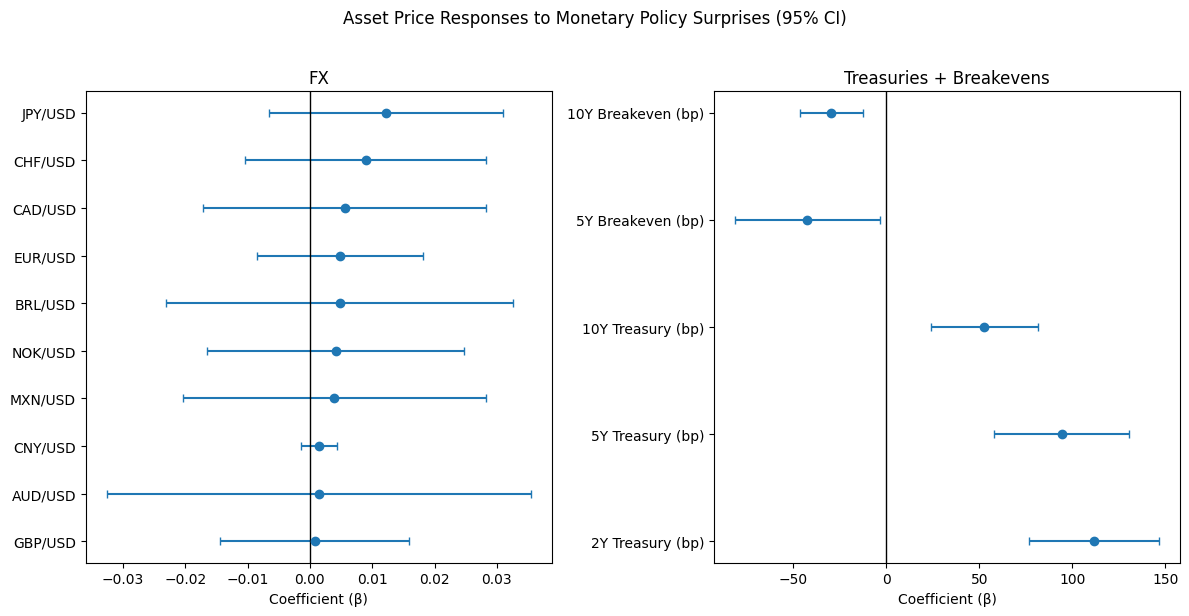

In [134]:
# -------------------------
# 1) coefficient plot (all assets, 95% CI)
# -------------------------

# copy results
df = results.copy()
df["asset"] = df["asset"].map(label_map)

# 95% CI
df["ci_lo"] = df["beta"] - 1.96 * df["se"]
df["ci_hi"] = df["beta"] + 1.96 * df["se"]

# split data
fx = df[df["asset_class"] == "FX"].copy().sort_values("beta").reset_index(drop=True)

rates = df[df["asset_class"].isin(["Yield", "TIPS"])].copy()

# order rates by maturity (manually)
order_rates = {
    "d_DGS2": 1,
    "d_DGS5": 2,
    "d_DGS10": 3,
    "d_T5YIE": 4,
    "d_T10YIE": 5,
}
rates["order"] = rates["asset"].map(order_rates)
rates = rates.sort_values("order").reset_index(drop=True)

# create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# -------- FX subplot --------
ax = axes[0]
y_pos = np.arange(len(fx))

ax.errorbar(
    fx["beta"].to_numpy(),
    y_pos,
    xerr=(1.96 * fx["se"]).to_numpy(),
    fmt="o",
    capsize=3
)

ax.axvline(0, color="black", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(fx["asset"])
ax.set_xlabel("Coefficient (β)")
ax.set_title("FX")

# -------- Rates subplot --------
ax = axes[1]
y_pos = np.arange(len(rates))

ax.errorbar(
    rates["beta"].to_numpy(),
    y_pos,
    xerr=(1.96 * rates["se"]).to_numpy(),
    fmt="o",
    capsize=3
)

ax.axvline(0, color="black", linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(rates["asset"])
ax.set_xlabel("Coefficient (β)")
ax.set_title("Treasuries + Breakevens")

fig.suptitle("Asset Price Responses to Monetary Policy Surprises (95% CI)", y=1.02)

plt.tight_layout()
plt.show()

fig.savefig("output/part2_coef_plot.png", dpi=300, bbox_inches="tight")


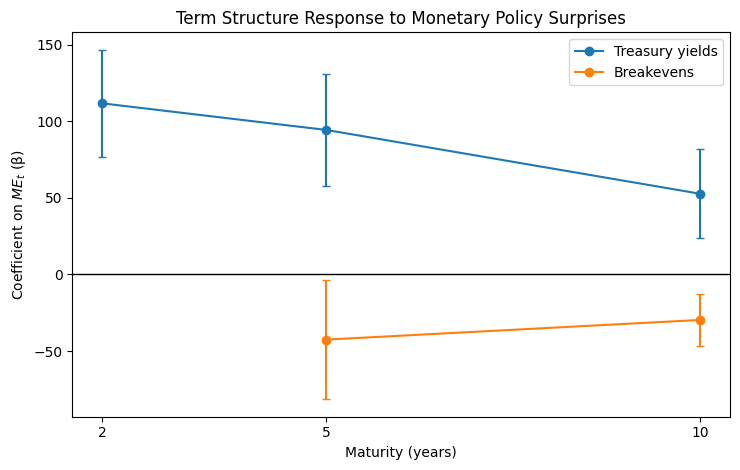

In [135]:
# -------------------------
# 2) Term structure plot (yields + breakevens)
# -------------------------

# Extract maturities and label series
term = results[results["asset"].isin(["d_DGS2", "d_DGS5", "d_DGS10", "d_T5YIE", "d_T10YIE"])].copy()

def maturity_years(asset):
    if asset == "d_DGS2": return 2
    if asset == "d_DGS5": return 5
    if asset == "d_DGS10": return 10
    if asset == "d_T5YIE": return 5
    if asset == "d_T10YIE": return 10
    return np.nan

def series_name(asset):
    if asset.startswith("d_DGS"): return "Treasury yields"
    if asset.startswith("d_T"): return "Breakevens"
    return "Other"

term["maturity"] = term["asset"].apply(maturity_years)
term["series"] = term["asset"].apply(series_name)
term = term.sort_values(["series", "maturity"])

# 95% CI
term["ci_lo"] = term["beta"] - 1.96 * term["se"]
term["ci_hi"] = term["beta"] + 1.96 * term["se"]

yields = term[term["series"] == "Treasury yields"]
beis   = term[term["series"] == "Breakevens"]

# ---- Create new figure properly ----
fig2, ax2 = plt.subplots(figsize=(7.5, 4.8))

# --- Yields ---
line_y, = ax2.plot(
    yields["maturity"],
    yields["beta"],
    marker="o",
    label="Treasury yields"
)

ax2.errorbar(
    yields["maturity"],
    yields["beta"],
    yerr=1.96 * yields["se"],
    fmt="none",
    capsize=3,
    color=line_y.get_color()
)

# --- Breakevens ---
line_b, = ax2.plot(
    beis["maturity"],
    beis["beta"],
    marker="o",
    label="Breakevens"
)

ax2.errorbar(
    beis["maturity"],
    beis["beta"],
    yerr=1.96 * beis["se"],
    fmt="none",
    capsize=3,
    color=line_b.get_color()
)

ax2.axhline(0, color="black", linewidth=1)
ax2.set_xlabel("Maturity (years)")
ax2.set_ylabel(r"Coefficient on $ME_t$ (β)")
ax2.set_title("Term Structure Response to Monetary Policy Surprises")
ax2.set_xticks(sorted(term["maturity"].dropna().unique()))
ax2.legend()

fig2.tight_layout()

# Save BEFORE show
fig2.savefig("output/part2_term_structure.png", dpi=300, bbox_inches="tight")

plt.show()


## Part 3: The Role of External Positions (25 points)

Recent research suggests that countries’ external financial positions affect how their currencies respond to U.S. monetary policy shocks (see Antol´ın-D´ıaz, Cenedese, Han, and Sarno, 2023).

Your task: Test whether the NFA/GDP ratio moderates exchange rate responses to U.S. monetary policy surprises.

Estimate a panel regression of the form:

$$\Delta e_{i,t} = \alpha_i + \beta_1 \cdot \text{Surprise}_t + \beta_2 \cdot  (\text{Surprise}_t \times \text{NFA}_{i,t-1}) + \gamma \cdot \text{NFA}_{i,t-1} + \varepsilon_{i,t}$$

where $\Delta e_{i,t}$ is the change in exchange rate $i$ on FOMC day $t$, and $\text{NFA}_{i,t-1}$ is the lagged NFA/GDP
ratio for country $i$.

Deliverables:

(a) Panel regression results with appropriate standard errors (discuss your choice: clustered by
country, by time, or two-way)

(b) A visualization showing how the estimated exchange rate response varies with NFA/GDP

In your writeup, explain your methodology, interpret the results economically, and discuss
any issues you think are important or challenging.

#### Data Processing: External Positions

In [136]:
nfa_gdp_data = external_positions_data.copy()

print(nfa_gdp_data.shape)
nfa_gdp_data.head()

(11770, 28)


,Country,IFS_Code,Year,Portfolio equity assets (stock),Portfolio equity liabilities (stock),FDI assets (stock),FDI liabilities (stock),Debt assets (stock),Debt liabilities (stock),financial derivatives (assets),financial derivatives (liab),FX Reserves minus gold,Total assets,Total liabilities,Net IIP excl gold,OFFICIAL IIP,GDP (US$),Portfolio debt assets,Portfolio debt liabilities,Other investment assets,Other investment liabilities,Monetary Gold,Current account balance,Capital account,Exchange rate (period avg),Exchange rate (end of period),net IIP excl gold / GDP domestic currency,net IIP / GDP domestic currency
0,"Afghanistan, I.R. of",512,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.95893,NaN,NaN,433.54769,438.43342,NaN,NaN
1,"Afghanistan, I.R. of",512,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.66316,NaN,NaN,433.54769,438.43342,NaN,NaN
2,"Afghanistan, I.R. of",512,1972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.4868,NaN,NaN,433.54769,438.43342,NaN,NaN
3,"Afghanistan, I.R. of",512,1973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.617,NaN,NaN,433.54769,438.43342,NaN,NaN
4,"Afghanistan, I.R. of",512,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173.818,NaN,NaN,433.54769,438.43342,NaN,NaN


In [137]:
# IIP = International Investment Position
# NFA = Net Foreign Assets (same thing)
# keep just "net IIP excl gold / GDP domestic currency" and "net IIP / GDP domestic currency"

nfa_gdp_data = nfa_gdp_data[["Country", "IFS_Code", "Year", "net IIP excl gold / GDP domestic currency", "net IIP / GDP domestic currency"]]
# external_positions_data.head()

# rename columns
nfa_gdp_data = nfa_gdp_data.rename(columns={
    "net IIP excl gold / GDP domestic currency": "NFA_GDP_excl_gold",
    "net IIP / GDP domestic currency": "NFA_GDP"
})

nfa_gdp_data.head()

,Country,IFS_Code,Year,NFA_GDP_excl_gold,NFA_GDP
0,"Afghanistan, I.R. of",512,1970,NaN,NaN
1,"Afghanistan, I.R. of",512,1971,NaN,NaN
2,"Afghanistan, I.R. of",512,1972,NaN,NaN
3,"Afghanistan, I.R. of",512,1973,NaN,NaN
4,"Afghanistan, I.R. of",512,1974,NaN,NaN


**Investigate gold**


Antolin-Diaz, EWN dataset seem to include it. In my naive intution, would think that gold does not contribute to foreign assets "at risk" or "exposed" to monetary policy shocks. Gold is a safe asset, which can help resist financial stress - would this dampen the effect of shocks opposite to the way having a large external financial position would? 

Hypothesis: high NFA -> large foreign exposure, including the USA -> more affected by monetary policy

Question: high gold -> reducing foreign exposure (potentially should not include in NFA) -> less affected by monetary policy, since gold is safe

**After research**

Antolin-Diaz:
>The NFA/GDP ratio proxies for a country’s external leverage and risk-bearing
capacity, so it captures how exposed its currency is to valuation and rollover risk when global
financial conditions, and in particular US monetary policy, tighten.

My logic is flipped:
- Higher NFA (net creditor) -> less exposed/vulnerable to US tightening
- Lower NFA (net debtor) -> more vulnerable

We should include gold.

#### Build panel

In [138]:
# get fx cols and country

fx_cols = [c for c in merged_event_study.columns if c.startswith("r_DEX")]
print(fx_cols)

fx_country_map = {
    "DEXEUUS": "Euro Area",
    "DEXUKUS": "United Kingdom",
    "DEXJPUS": "Japan",
    "DEXSZUS": "Switzerland",
    "DEXALUS": "Australia",
    "DEXCAUS": "Canada",
    "DEXMXUS": "Mexico",
    "DEXNOUS": "Norway",
    "DEXBZUS": "Brazil",
    "DEXCHUS": "China,P.R.: Mainland"
}

['r_DEXEUUS', 'r_DEXUKUS', 'r_DEXJPUS', 'r_DEXSZUS', 'r_DEXALUS', 'r_DEXCAUS', 'r_DEXMXUS', 'r_DEXNOUS', 'r_DEXBZUS', 'r_DEXCHUS']


In [139]:
# Build panel
# row per (country, event_date)
# dependent variable: r_FX
# independent variable: ME
# controls: NFA/GDP (and interaction term)

# copy
df = merged_event_study.copy()
df = df.reset_index()

# melt (to long)
panel_df = df.melt(
    id_vars=["index", "ME"],
    value_vars=fx_cols,
    var_name="asset",
    value_name="r_FX"
)

# rename index to date
panel_df = panel_df.rename(columns={"index": "date"})

# add country
panel_df["country"] = panel_df["asset"].str.replace("r_", "").map(fx_country_map)
# print(panel_df[panel_df["Country"].isna()]) # check bad matches

# pull out year, lag it
panel_df["year"] = panel_df["date"].dt.year
panel_df["year_tm1"] = panel_df["year"] - 1

print(panel_df)

           date        ME      asset      r_FX               country  year  year_tm1
0    1999-02-03  0.012041  r_DEXEUUS -0.000971             Euro Area  1999      1998
1    1999-03-30 -0.008825  r_DEXEUUS -0.001492             Euro Area  1999      1998
2    1999-05-18  0.074697  r_DEXEUUS  0.000000             Euro Area  1999      1998
3    1999-06-30 -0.057555  r_DEXEUUS  0.002615             Euro Area  1999      1998
4    1999-08-24  0.009345  r_DEXEUUS  0.004464             Euro Area  1999      1998
...         ...       ...        ...       ...                   ...   ...       ...
2295 2025-07-30  0.048209  r_DEXCHUS  0.002296  China,P.R.: Mainland  2025      2024
2296 2025-09-17 -0.004008  r_DEXCHUS -0.001533  China,P.R.: Mainland  2025      2024
2297 2025-10-29  0.069356  r_DEXCHUS -0.000113  China,P.R.: Mainland  2025      2024
2298 2025-12-10 -0.011100  r_DEXCHUS  0.000099  China,P.R.: Mainland  2025      2024
2299 2026-01-28  0.008101  r_DEXCHUS -0.001194  China,P.R.: Mainl

In [140]:
# merge with nfa_gdp_data
panel_df = panel_df.merge(
    nfa_gdp_data,
    left_on=["country", "year_tm1"],
    right_on=["Country", "Year"],
    how="left"
)
print(panel_df.head())

# drop unnecessary
panel_df = panel_df.drop(columns=["Country", "IFS_Code", "Year", "NFA_GDP_excl_gold"])
print(panel_df.shape)
panel_df.head()

        date        ME      asset      r_FX    country  year  year_tm1    Country  IFS_Code    Year  NFA_GDP_excl_gold  NFA_GDP
0 1999-02-03  0.012041  r_DEXEUUS -0.000971  Euro Area  1999      1998  Euro Area     163.0  1998.0                NaN      NaN
1 1999-03-30 -0.008825  r_DEXEUUS -0.001492  Euro Area  1999      1998  Euro Area     163.0  1998.0                NaN      NaN
2 1999-05-18  0.074697  r_DEXEUUS  0.000000  Euro Area  1999      1998  Euro Area     163.0  1998.0                NaN      NaN
3 1999-06-30 -0.057555  r_DEXEUUS  0.002615  Euro Area  1999      1998  Euro Area     163.0  1998.0                NaN      NaN
4 1999-08-24  0.009345  r_DEXEUUS  0.004464  Euro Area  1999      1998  Euro Area     163.0  1998.0                NaN      NaN
(2300, 8)


,date,ME,asset,r_FX,country,year,year_tm1,NFA_GDP
0,1999-02-03,0.012041,r_DEXEUUS,-0.000971,Euro Area,1999,1998,NaN
1,1999-03-30,-0.008825,r_DEXEUUS,-0.001492,Euro Area,1999,1998,NaN
2,1999-05-18,0.074697,r_DEXEUUS,0.000000,Euro Area,1999,1998,NaN
3,1999-06-30,-0.057555,r_DEXEUUS,0.002615,Euro Area,1999,1998,NaN
4,1999-08-24,0.009345,r_DEXEUUS,0.004464,Euro Area,1999,1998,NaN


In [141]:
# check NaNs
print(panel_df.isna().sum())

date          0
ME            0
asset         0
r_FX         10
country       0
year          0
year_tm1      0
NFA_GDP     123
dtype: int64


In [142]:
# drop NAs

panel_df = panel_df.dropna()
print(panel_df.shape)
print(panel_df.isna().sum())
panel_df.head()

(2167, 8)
date        0
ME          0
asset       0
r_FX        0
country     0
year        0
year_tm1    0
NFA_GDP     0
dtype: int64


,date,ME,asset,r_FX,country,year,year_tm1,NFA_GDP
8,2000-02-02,0.004194,r_DEXEUUS,-0.003795,Euro Area,2000,1999,-0.053318
9,2000-03-21,0.008544,r_DEXEUUS,0.000721,Euro Area,2000,1999,-0.053318
10,2000-05-16,0.043280,r_DEXEUUS,0.009345,Euro Area,2000,1999,-0.053318
11,2000-06-28,-0.015516,r_DEXEUUS,0.000000,Euro Area,2000,1999,-0.053318
12,2000-08-22,0.017150,r_DEXEUUS,0.006892,Euro Area,2000,1999,-0.053318


### Run Regression (time clustering, `statsmodels`)


In [143]:
# build formula

# equivalent, with implied interaction term breakdown
# formula = "r_FX ~ ME * NFA_GDP"

formula = "r_FX ~ ME + ME:NFA_GDP + NFA_GDP + C(country)"

In [144]:
# run regression

res_ols = smf.ols(formula, data=panel_df).fit()

res_time = res_ols.get_robustcov_results(
    cov_type="cluster",
    groups=pd.to_datetime(panel_df["date"])
)

print(res_time.summary())

                            OLS Regression Results                            
Dep. Variable:                   r_FX   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     1.088
Date:                Thu, 19 Feb 2026   Prob (F-statistic):              0.371
Time:                        00:20:01   Log-Likelihood:                 7672.8
No. Observations:                2167   AIC:                        -1.532e+04
Df Residuals:                    2154   BIC:                        -1.525e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

/opt/homebrew/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/homebrew/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/homebrew/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


### Run Regression (two-way clustering, `linearmodels`)

Attempt to use `linearmodels` for two way clustering. Note we only have 10 countries, clustering requires ~>30 to work well.

Regression breaks with 8 currencies (2 additional), but works with 10 (4 additional). In 8 currency regression, interaction term has no SE

https://economics.stackexchange.com/questions/45432/why-we-need-at-least-40-groups-to-be-properly-clustered#:~:text=Consequently%2C%20if%20you%20are%20willing%20to%20tolerate,use%2030%20as%20a%20rule%20of%20thumb.

https://stats.stackexchange.com/questions/185378/when-to-use-fixed-effects-vs-using-cluster-ses

In [145]:
from linearmodels.panel import PanelOLS

In [146]:
# prep

panel_df_tw = panel_df.copy()

# date to datetime (to ensure)
panel_df_tw["date"] = pd.to_datetime(panel_df_tw["date"])

# interaction
panel_df_tw["ME_x_NFA"] = panel_df_tw["ME"] * panel_df_tw["NFA_GDP"]

# set panel index
panel_df_tw = panel_df_tw.set_index(["country", "date"]).sort_index()

In [147]:
# check

# NAs
print(panel_df_tw.isna().sum())

# Infinites
print(panel_df_tw.isin([np.inf, -np.inf]).sum())

# describe
print(panel_df_tw.describe())

ME          0
asset       0
r_FX        0
year        0
year_tm1    0
NFA_GDP     0
ME_x_NFA    0
dtype: int64
ME          0
asset       0
r_FX        0
year        0
year_tm1    0
NFA_GDP     0
ME_x_NFA    0
dtype: int64
                ME         r_FX         year     year_tm1      NFA_GDP     ME_x_NFA
count  2167.000000  2167.000000  2167.000000  2167.000000  2167.000000  2167.000000
mean      0.000834    -0.000543  2012.536687  2011.536687     0.182799     0.000290
std       0.038746     0.007032     7.538722     7.538722     0.689793     0.025838
min      -0.281902    -0.066666  1999.000000  1998.000000    -0.604545    -0.301457
25%      -0.009916    -0.003254  2006.000000  2005.000000    -0.302667    -0.004146
50%       0.005671    -0.000305  2013.000000  2012.000000    -0.053318    -0.000123
75%       0.017105     0.002182  2019.000000  2018.000000     0.517792     0.005277
max       0.096965     0.081141  2025.000000  2024.000000     3.782974     0.262371


In [148]:
# chatgpt diagnostic 1
df = panel_df_tw.copy().reset_index()
df["ME_x_NFA"] = df["ME"] * df["NFA_GDP"]

for c in ["ME", "NFA_GDP", "ME_x_NFA"]:
    df[c + "_dm"] = df[c] - df.groupby("country")[c].transform("mean")

print(df[["ME_dm","NFA_GDP_dm","ME_x_NFA_dm"]].std())
print((df.groupby("country")[["ME_dm","NFA_GDP_dm","ME_x_NFA_dm"]].std() < 1e-12).sum())

# chatgpt diagnostic 2
Xw = df[["ME_dm","NFA_GDP_dm","ME_x_NFA_dm"]].to_numpy()
print("rank:", np.linalg.matrix_rank(Xw), "k:", Xw.shape[1])
print("cond:", np.linalg.cond(Xw))


ME_dm          0.038733
NFA_GDP_dm     0.353369
ME_x_NFA_dm    0.025814
dtype: float64
ME_dm          0
NFA_GDP_dm     0
ME_x_NFA_dm    0
dtype: int64
rank: 3 k: 3
cond: 14.538059179996047


In [149]:
# run regression

y = panel_df_tw["r_FX"]
X = panel_df_tw[["ME", "ME_x_NFA", "NFA_GDP"]]

mod = PanelOLS(y, X, entity_effects=True) # entity_effects for alpha_i
res_tw = mod.fit(cov_type="clustered", cluster_time=True, cluster_entity=True)

print(res_tw.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                   r_FX   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.1673
No. Observations:                2167   R-squared (Within):               0.0009
Date:                Thu, Feb 19 2026   R-squared (Overall):              0.0025
Time:                        00:20:01   Log-likelihood                    7672.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.6208
Entities:                          10   P-value                           0.6016
Avg Obs:                       216.70   Distribution:                  F(3,2154)
Min Obs:                       177.00                                           
Max Obs:                       228.00   F-statistic (robust):             2.2001
                            

/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:1996: RuntimeWarning: divide by zero encountered in matmul
  weps = y - x @ params
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:1996: RuntimeWarning: overflow encountered in matmul
  weps = y - x @ params
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:1996: RuntimeWarning: invalid value encountered in matmul
  weps = y - x @ params
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:2007: RuntimeWarning: divide by zero encountered in matmul
  fitted = DataFrame(_x @ params, index, ["fitted_values"])
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:2007: RuntimeWarning: overflow encountered in matmul
  fitted = DataFrame(_x @ params, index, ["fitted_values"])
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:2007: RuntimeWarning: invalid value encountered in matmul
  fitted = DataFrame(_x @ params, index, [

### Run Regression (Driscoll-Kraay, `linearmodels`)

Trying alternative SE method: Driscoll-Kraay (`linearmodels`)

https://vincent.codes.finance/posts/panel-ols-standard-errors/#driscoll-kraay-standard-errors

In [150]:
from linearmodels.panel import PanelOLS

panel_df_dk = panel_df.copy()

panel_df_dk["date"] = pd.to_datetime(panel_df_dk["date"])
panel_df_dk["country"] = panel_df_dk["country"].astype("category")

# interaction term
panel_df_dk["ME_x_NFA"] = panel_df_dk["ME"] * panel_df_dk["NFA_GDP"]

# panel index
panel_df_dk = panel_df_dk.set_index(["country", "date"]).sort_index()

print(panel_df_dk.shape)
panel_df_dk.head()

(2167, 7)


ME      asset      r_FX  year  year_tm1   NFA_GDP  ME_x_NFA
country   date                                                                         
Australia 1999-02-03  0.012041  r_DEXALUS -0.002185  1999      1998 -0.520602 -0.006268
          1999-03-30 -0.008825  r_DEXALUS  0.008417  1999      1998 -0.520602  0.004595
          1999-05-18  0.074697  r_DEXALUS -0.006434  1999      1998 -0.520602 -0.038887
          1999-06-30 -0.057555  r_DEXALUS -0.004700  1999      1998 -0.520602  0.029963
          1999-08-24  0.009345  r_DEXALUS -0.001728  1999      1998 -0.520602 -0.004865

In [151]:
# run regression

y = panel_df_dk["r_FX"]
X = panel_df_dk[["ME", "NFA_GDP", "ME_x_NFA"]]

mod = PanelOLS(y, X, entity_effects=True)

# code from ChatGPT
res_dk = mod.fit(
    cov_type="kernel",     # Driscoll–Kraay-style
    kernel="bartlett",     # Newey–West kernel (default-style)
    bandwidth=8            # choose a lag length (see note below)
)

print(res_dk.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                   r_FX   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.1673
No. Observations:                2167   R-squared (Within):               0.0009
Date:                Thu, Feb 19 2026   R-squared (Overall):              0.0025
Time:                        00:20:01   Log-likelihood                    7672.8
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      0.6208
Entities:                          10   P-value                           0.6016
Avg Obs:                       216.70   Distribution:                  F(3,2154)
Min Obs:                       177.00                                           
Max Obs:                       228.00   F-statistic (robust):             0.6549
                            

/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/data.py:595: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/data.py:595: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:1996: RuntimeWarning: divide by zero encountered in matmul
  weps = y - x @ params
/opt/homebrew/lib/python3.13/site-packages/linearmodels/panel/model.py:1996: RuntimeWarning: ove

### Build Deliverables

#### Regression Table

In [152]:
# time-clustered as main spec
# two-way, Driscoll-Kraay as robustness checks

# -------------------------
# Helpers
# -------------------------
def extract_statsmodels(res, term):
    names = list(res.model.exog_names)
    if term not in names:
        raise KeyError(f"Term '{term}' not found. Available terms: {names}")
    j = names.index(term)
    beta = float(np.asarray(res.params)[j])
    se   = float(np.asarray(res.bse)[j])
    pval = float(np.asarray(res.pvalues)[j])
    return beta, se, pval

def extract_linearmodels(res, term):
    return float(res.params[term]), float(res.std_errors[term]), float(res.pvalues[term])

def fmt_beta(beta, p, decimals=5):
    return f"{beta:.{decimals}f}{stars(p)}"

def fmt_se(se, decimals=5):
    return f"({se:.{decimals}f})"

# -------------------------
# Term labels / mapping
# -------------------------
term_order = ["ME", "NFA_GDP", "ME_x_NFA"]
term_labels = {
    "ME": "Monetary policy surprise (ME)",
    "NFA_GDP": "NFA/GDP (t−1)",
    "ME_x_NFA": "ME × NFA/GDP (t−1)",
}
statsmodels_names = {"ME": "ME", "NFA_GDP": "NFA_GDP", "ME_x_NFA": "ME:NFA_GDP"}
lm_names         = {"ME": "ME", "NFA_GDP": "NFA_GDP", "ME_x_NFA": "ME_x_NFA"}

# -------------------------
# Build esttab-style stacked rows
# -------------------------
rows = []
for t in term_order:
    b1, se1, p1 = extract_statsmodels(res_time, statsmodels_names[t])
    b2, se2, p2 = extract_linearmodels(res_tw, lm_names[t])
    b3, se3, p3 = extract_linearmodels(res_dk, lm_names[t])

    # coefficient row
    rows.append({
        "": term_labels[t],
        "(1)": fmt_beta(b1, p1),
        "(2)": fmt_beta(b2, p2),
        "(3)": fmt_beta(b3, p3),
    })
    # std error row (blank label, SEs in parentheses)
    rows.append({
        "": "",
        "(1)": fmt_se(se1),
        "(2)": fmt_se(se2),
        "(3)": fmt_se(se3),
    })

# Model stats at bottom (like esttab)
N1 = int(getattr(res_time, "nobs", np.nan))
R21 = float(getattr(res_time, "rsquared", np.nan))
N2 = int(res_tw.nobs); R22 = float(res_tw.rsquared)
N3 = int(res_dk.nobs); R23 = float(res_dk.rsquared)

rows += [
    {"": "N",   "(1)": f"{N1}",      "(2)": f"{N2}",      "(3)": f"{N3}"},
    {"": r"$R^2$", "(1)": f"{R21:.5f}", "(2)": f"{R22:.5f}", "(3)": f"{R23:.5f}"},
]

panel_tbl = pd.DataFrame(rows)

# -------------------------
# Great Tables -> LaTeX
# -------------------------
gt = (
    GT(panel_tbl)
    .tab_header(
        title="External Positions and Exchange Rate Responses to U.S. Monetary Policy Surprises",
        subtitle=(
            r"$\Delta e_{i,t} = \alpha_i + \beta_1 ME_t + \beta_2(ME_t \times NFA_{i,t-1})"
            r" + \gamma NFA_{i,t-1} + \varepsilon_{i,t}$; country fixed effects."
        )
    )
    .tab_spanner(label=r"Dependent variable: $\Delta e_{i,t}$", columns=["(1)", "(2)", "(3)"])
    .cols_label(**{"": "", "(1)": "Time-clustered", "(2)": "Two-way clustered", "(3)": "Driscoll–Kraay"})
    .tab_source_note(
        source_note=r"Standard errors in parentheses. Significance: *** p<0.01, ** p<0.05, * p<0.10."
    )
)

latex = gt.as_latex()

# shrink font + tighten columns like you did before
# latex = latex.replace(
#     "\\begin{tabular*}",
#     "\\fontsize{7}{8.5}\\selectfont\n\\setlength{\\tabcolsep}{3pt}\n\\begin{tabular*}"
# )

# OPTIONAL: make the SE rows slightly smaller in LaTeX by wrapping parentheses rows
# (Great Tables doesn't have a perfect hook for this yet, so this is a simple post-process.)
# If you don't want this, delete this block.
latex = latex.replace("\n((", "\n\\footnotesize ((")  # harmless if pattern never occurs
latex = latex.replace("\n(", "\n\\footnotesize (")   # makes all SE rows smaller

print(latex)

\begin{table}[!t]
\caption*{
{\large External Positions and Exchange Rate Responses to U.S. Monetary Policy Surprises} \\
{\small \$\\Delta e\_\{i,t\} = \\alpha\_i + \\beta\_1 ME\_t + \\beta\_2(ME\_t \\times NFA\_\{i,t-1\}) + \\gamma NFA\_\{i,t-1\} + \\varepsilon\_\{i,t\}\$; country fixed effects.}
} 

\fontsize{12.0pt}{14.4pt}\selectfont

\begin{tabular*}{\linewidth}{@{\extracolsep{\fill}}lrrr}
\toprule
 & \multicolumn{3}{c}{Dependent variable: \$\\Delta e\_\{i,t\}\$} \\ 
\cmidrule(lr){2-4}
 & Time-clustered & Two-way clustered & Driscoll–Kraay \\ 
\midrule\addlinespace[2.5pt]
Monetary policy surprise (ME) & 0.00344 & 0.00344 & 0.00344 \\
 & (0.00692) & (0.00573) & (0.00573) \\
NFA/GDP (t−1) & -0.00041 & -0.00041* & -0.00041 \\
 & (0.00045) & (0.00023) & (0.00050) \\
ME × NFA/GDP (t−1) & 0.00192 & 0.00192 & 0.00192 \\
 & (0.00633) & (0.00373) & (0.00508) \\
N & 2167 & 2167 & 2167 \\
\$R\^2\$ & 0.00426 & 0.00086 & 0.00086 \\
\bottomrule
\end{tabular*}
\begin{minipage}{\linewidth}
Stand

#### Visualizations

From ChatGPT: marginal effect plot. How does the exchange rate response change as NFA increases?

Panel regression:

$$
\Delta e_{i,t}
=
\alpha_i
+
\beta_1 ME_t
+
\beta_2 (ME_t \times NFA_{i,t-1})
+
\gamma NFA_{i,t-1}
+
\varepsilon_{i,t}.
$$

Marginal effect of a monetary policy surprise (derivative):

$$
\frac{\partial \Delta e_{i,t}}{\partial ME_t}
=
\beta_1
+
\beta_2 \cdot NFA_{i,t-1}
$$



Variance–covariance matrix of the estimated coefficients
$(\hat{\beta}_1, \hat{\beta}_2)$:

$$
\widehat{\Sigma}
=
\begin{pmatrix}
\mathrm{Var}(\beta_1) & \mathrm{Cov}(\beta_1,\beta_2) \\
\mathrm{Cov}(\beta_1,\beta_2) & \mathrm{Var}(\beta_2)
\end{pmatrix}
$$

Variance rules (delta method):

$$
\mathrm{Var}\!\left(
\frac{\partial \Delta e_{i,t}}{\partial ME_t}
\right)
=
\mathrm{Var}(\beta_1)
+
NFA_{i,t-1}^2 \mathrm{Var}(\beta_2)
+
2 NFA_{i,t-1} \mathrm{Cov}(\beta_1,\beta_2).
$$


95\% confidence interval:

$$
m(NFA)
\pm
1.96 \sqrt{\mathrm{Var}\!\left(m(NFA)\right)}
$$

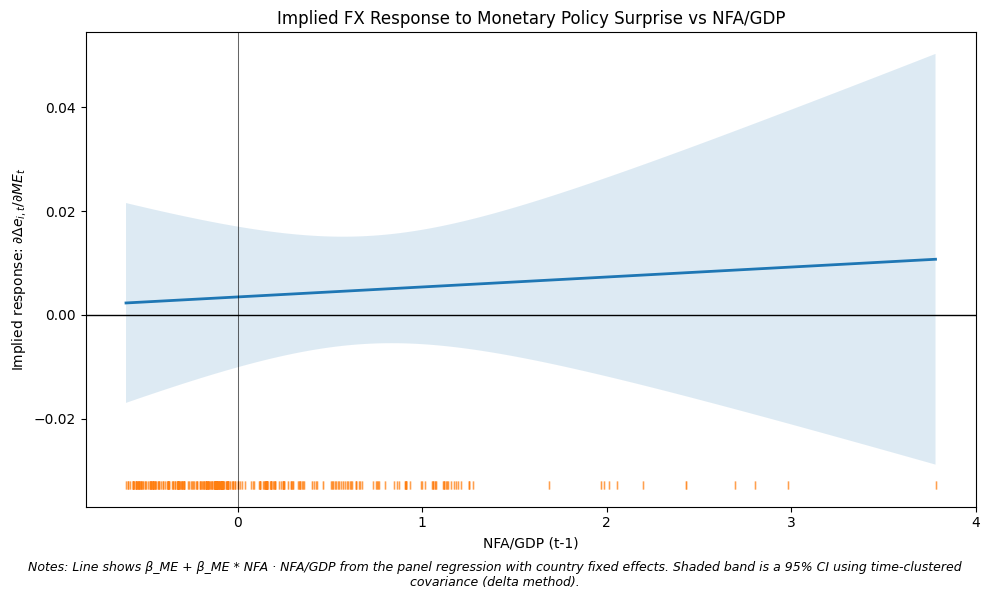

In [153]:
# Author note:
#   majority ChatGPT output
#   added formatting, read through to understand at a high level
#   not familiar with this (delta method), but feels similar to experience in econometrics - able to pick up, not to build from scratch

# -------------------------
# 1) Grab coefficients and covariance from the time-clustered model
# -------------------------
# Statsmodels stores parameters in the same order as exog_names
param_names = list(res_time.model.exog_names)

idx_me = param_names.index("ME")
idx_me_x_nfa = param_names.index("ME:NFA_GDP")

params = np.asarray(res_time.params)
cov = np.asarray(res_time.cov_params())

# Coefficients
beta_me = float(params[idx_me])
beta_me_x_nfa = float(params[idx_me_x_nfa])

# Variances + covariance for delta method
var_beta_me = float(cov[idx_me, idx_me])
var_beta_me_x_nfa = float(cov[idx_me_x_nfa, idx_me_x_nfa])
cov_me_me_x_nfa = float(cov[idx_me, idx_me_x_nfa])

# -------------------------
# 2) Build an NFA grid using your sample distribution
# -------------------------
nfa_values = panel_df["NFA_GDP"].to_numpy()

# Use full range of NFA values
x_left, x_right = np.nanmin(nfa_values), np.nanmax(nfa_values)
nfa_grid = np.linspace(x_left, x_right, 200)

# Implied marginal effect line: beta_me + beta_me_x_nfa * NFA
effect_hat = beta_me + beta_me_x_nfa * nfa_grid

# Delta-method standard error for: effect_hat = beta_me + nfa * beta_me_x_nfa
# Var(effect) = Var(beta_me) + nfa^2 Var(beta_me_x_nfa) + 2*nfa*Cov(beta_me, beta_me_x_nfa)
effect_var = (
    var_beta_me
    + (nfa_grid ** 2) * var_beta_me_x_nfa
    + 2 * nfa_grid * cov_me_me_x_nfa
)
effect_se = np.sqrt(np.maximum(effect_var, 0))

ci_lo = effect_hat - 1.96 * effect_se
ci_hi = effect_hat + 1.96 * effect_se

# -------------------------
# 3) Plot (match your other style)
# -------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Confidence band + implied effect line
ax.fill_between(nfa_grid, ci_lo, ci_hi, alpha=0.15, linewidth=0)
ax.plot(nfa_grid, effect_hat, linewidth=2)

# Optional: rug plot to show where the data live on x-axis
ymin, ymax = ax.get_ylim()
ax.plot(nfa_values, np.full_like(nfa_values, ymin), "|", markersize=6, alpha=0.15)

# Reference lines
ax.axhline(0, color="black", linewidth=1)
ax.axvline(0, color="black", linewidth=0.75, alpha=0.6)

ax.set_title("Implied FX Response to Monetary Policy Surprise vs NFA/GDP")
ax.set_xlabel("NFA/GDP (t-1)")
ax.set_ylabel(r"Implied response: $\partial \Delta e_{i,t} / \partial ME_t$")

note = (
    "Notes: Line shows β_ME + β_ME * NFA · NFA/GDP from the panel regression with country fixed effects. "
    "Shaded band is a 95% CI using time-clustered covariance (delta method)."
)
fig.text(0.5, 0.01, note, ha="center", va="bottom", fontsize=9, style="italic", wrap=True)

fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

fig.savefig("output/part3_nfa_marginal_effect.png", dpi=300, bbox_inches="tight")


## Part 4: Extension

Propose and implement one extension that deepens or improves the analysis. This is deliberately
open-ended.

We evaluate:
- The quality of your idea (does it address something interesting or important?)
- The quality of execution
- Your interpretation of the results

Local projections for impulse response curves.

Limitation with Part 2 event-study regressions: they estimate only the announcement-day response of asset prices to monetary policy surprises. Our monetary policy surprise is measured in a short intra-day window to the FOMC meeting and press conference, while our dependent variables (FX, yields, TIPS spread) is daily.

Hypothesis: effect of monetary policy surprise may not be on-impact/within same day (especially if close times for daily prices are different, e.g. in U.S. vs. Europe vs. Asia - have not investigated this). Prices may adjust gradually.

To assess whether monetary policy surprises generate delayed or cumulative asset-price responses over subsequent trading days, we estimate impulse responses using local projections (Jorda, 2005). Inspired by another coding exercise done for a different MIT research associate position.


Also, can draw similarities to Post-earnings-announcement drift:
> (PEAD) is a well-documented financial anomaly where a stock's price continues to move in the direction of an earnings surprise for weeks or months after the announcement.

Hypothesis that a currency pair/FX rate will move in the direction of a monetary policy surprise for weeks (or months) after the announcement.

In Part 2, we estimate:

$$
\Delta y_{i,t} = \alpha_i + \beta_i \cdot \text{ME}_t + \varepsilon_{i,t}
$$

where $\text{ME}_t$ is the monetary policy surprise based on monetary events (statements and press conferences) (principal component),

and for $\Delta y_{i,t} = y_{i,t} - y_{i,t-1}$ as the event day change in:
- Each exchange rate (8+ currencies) - log difference
- Each Treasury yield (2Y, 5Y, 10Y) - basis point difference
- Each breakeven inflation rate (5Y, 10Y) - basis point difference

Here in Part 4, we will estimate cumulative change over time, rather than single-day change.
<!-- 
$$
Y_{i,t}(h) = \alpha_{i,h} + \beta_{i,h} \cdot ME_t + u_{i,t}(h)
$$ -->

$$
Y_{i,t}(h)
=
\alpha_{i,h}
+
\beta_{i,h} \cdot ME_t
+
\sum_{j=1}^{2} \gamma_{i,j,h} ME_{t-j}
+
u_{i,t}(h),
$$

We forward-look to `h` days after the FOMC meeting, stopping before the next meeting.

Note we also include 2 lags, to account for the past 2 FOMC meetings and their residual effects.

We define $Y_{i,t}(h)$ as the cumulative change in asset $i$ from date $t$ to $t+h$

$$
Y_{i,t}(h) \equiv y_{i,t+h} - y_{i,t-1}.
$$



### Data Cleaning and Prep

In [154]:
# restating

# dependent variables
exchange_rates = ['DEXUSEU', 'DEXUSUK', 'DEXJPUS', 'DEXSZUS', 'DEXUSAL', 'DEXCAUS']
additional_exchange_rates = ['DEXMXUS', 'DEXNOUS', 'DEXBZUS', 'DEXCHUS']
treasury_yields = ['DGS2', 'DGS5', 'DGS10']
breakeven_inflation = ['T5YIE', 'T10YIE']

In [155]:
# bring back the data from Part 2

merged_drift = merged.copy()

# drop log-diff and diff columns used in Part 2
# drop all columsn starting with "r_" and "d_"
merged_drift = merged_drift.drop(columns=[col for col in merged_drift.columns if col.startswith("r_") or col.startswith("d_")])

# convert FX to log, no diff
merged_drift["log_DEXEUUS"] = np.log(merged_drift["DEXEUUS"])
merged_drift["log_DEXUKUS"] = np.log(merged_drift["DEXUKUS"])
merged_drift["log_DEXJPUS"] = np.log(merged_drift["DEXJPUS"])
merged_drift["log_DEXSZUS"] = np.log(merged_drift["DEXSZUS"])
merged_drift["log_DEXALUS"] = np.log(merged_drift["DEXALUS"])
merged_drift["log_DEXCAUS"] = np.log(merged_drift["DEXCAUS"])
merged_drift["log_DEXMXUS"] = np.log(merged_drift["DEXMXUS"])
merged_drift["log_DEXNOUS"] = np.log(merged_drift["DEXNOUS"])
merged_drift["log_DEXBZUS"] = np.log(merged_drift["DEXBZUS"])
merged_drift["log_DEXCHUS"] = np.log(merged_drift["DEXCHUS"])


# convert yield and tips to basis points
merged_drift["bp_DGS2"] = merged_drift["DGS2"] * 100
merged_drift["bp_DGS5"] = merged_drift["DGS5"] * 100
merged_drift["bp_DGS10"] = merged_drift["DGS10"] * 100
merged_drift["bp_T5YIE"] = merged_drift["T5YIE"] * 100
merged_drift["bp_T10YIE"] = merged_drift["T10YIE"] * 100

# confirm index/sorting
merged_drift = merged_drift.sort_index().copy()

merged_drift

,DEXEUUS,DEXUKUS,DEXJPUS,DEXSZUS,DEXALUS,DEXCAUS,DEXMXUS,DEXNOUS,DEXBZUS,DEXCHUS,DGS2,DGS5,DGS10,T5YIE,T10YIE,ME,log_DEXEUUS,log_DEXUKUS,log_DEXJPUS,log_DEXSZUS,log_DEXALUS,log_DEXCAUS,log_DEXMXUS,log_DEXNOUS,log_DEXBZUS,log_DEXCHUS,bp_DGS2,bp_DGS5,bp_DGS10,bp_T5YIE,bp_T10YIE
1994-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.079303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.026771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-05-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.019137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-09,0.840477,0.731689,156.08,0.7679,1.411034,1.3570,17.1896,9.5869,5.1906,6.9200,3.48,3.75,4.22,2.50,2.35,NaN,-0.173785,-0.312399,5.050369,-0.264096,0.344323,0.305276,2.844305,2.260398,1.646849,1.934416,348.0,375.0,422.0,250.0,235.0
2026-02-10,0.840477,0.731850,154.28,0.7668,1.414027,1.3533,17.2201,9.5268,5.1993,6.9106,3.45,3.70,4.16,2.47,2.32,NaN,-0.173785,-0.312180,5.038769,-0.265529,0.346442,0.302546,2.846077,2.254109,1.648524,1.933056,345.0,370.0,416.0,247.0,232.0
2026-02-11,0.841468,0.732386,152.93,0.7700,1.402721,1.3569,17.1984,9.4677,5.1756,6.9125,3.52,3.75,4.18,2.49,2.32,NaN,-0.172608,-0.311447,5.029980,-0.261365,0.338414,0.305203,2.844816,2.247886,1.643955,1.933331,352.0,375.0,418.0,249.0,232.0
2026-02-12,0.842460,0.733568,152.64,0.7693,1.409046,1.3623,17.2309,9.5251,5.1967,6.9010,3.47,3.67,4.09,2.45,2.29,NaN,-0.171429,-0.309835,5.028082,-0.262274,0.342913,0.309174,2.846704,2.253930,1.648024,1.931666,347.0,367.0,409.0,245.0,229.0


In [156]:
# days until next meeting - limts our horizon

def prep_meeting_calendar(df, surprise=indep):
    df = df.sort_index().copy()

    # meeting days only
    meet = df[df[surprise].notna()].copy()

    meet["next_meeting_date"] = meet.index.to_series().shift(-1)
    meet["days_to_next_meeting"] = (meet["next_meeting_date"] - meet.index).dt.days

    return meet[["days_to_next_meeting"]]

meeting_info = prep_meeting_calendar(merged_drift, surprise="ME")
print(meeting_info)

merged_drift = merged_drift.join(meeting_info, how="left")
print(merged_drift.head())

            days_to_next_meeting
1994-02-04                  46.0
1994-03-22                  27.0
1994-04-18                  29.0
1994-05-17                  50.0
1994-07-06                  41.0
...                          ...
2025-07-30                  49.0
2025-09-17                  42.0
2025-10-29                  42.0
2025-12-10                  49.0
2026-01-28                   NaN

[274 rows x 1 columns]
            DEXEUUS  DEXUKUS  DEXJPUS  DEXSZUS  DEXALUS  DEXCAUS  DEXMXUS  DEXNOUS  DEXBZUS  DEXCHUS  DGS2  DGS5  DGS10  T5YIE  T10YIE        ME  log_DEXEUUS  log_DEXUKUS  log_DEXJPUS  log_DEXSZUS  log_DEXALUS  log_DEXCAUS  log_DEXMXUS  \
1994-02-04      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   NaN   NaN    NaN    NaN     NaN  0.079303          NaN          NaN          NaN          NaN          NaN          NaN          NaN   
1994-03-22      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  

In [157]:
# dependent variables
fx_deps = ["log_DEXEUUS", "log_DEXUKUS", "log_DEXJPUS", "log_DEXSZUS", "log_DEXALUS", "log_DEXCAUS", "log_DEXMXUS", "log_DEXNOUS", "log_DEXBZUS", "log_DEXCHUS"]
yield_deps = ["bp_DGS2", "bp_DGS5", "bp_DGS10"]
tips_deps = ["bp_T5YIE", "bp_T10YIE"]

deps = fx_deps + yield_deps + tips_deps

# independent variable
indep = "ME"

# horizons
H = 40

### Run one dep, one H

In [158]:
def run_local_projection_one_dep_one_h(df, dep, asset_class, h, surprise=indep):

    # re-sort for safety
    df = df.sort_index().copy()

    # build Y (cumulative change, outcome)
    Y = df[dep].shift(-h) - df[dep].shift(1)

    # build
    reg_df = pd.DataFrame({
        "Y": Y,
        "ME": df[surprise],
        "days_to_next_meeting": df["days_to_next_meeting"]
    })

    # clean up NAs (filter to event days)
    reg_df = reg_df.dropna(subset=["ME", "days_to_next_meeting"]).copy()


    # key restriction: horizon must end before next meeting
    # sample size will drop off quickly as h increases past ~30-40
    reg_df = reg_df[reg_df["days_to_next_meeting"] > h].copy()

    # check NAs
    # print(reg_df.isna().sum())
    # print(reg_df.shape)

    # lagged FOMC
    reg_df["ME_tm1"] = reg_df["ME"].shift(1)
    reg_df["ME_tm2"] = reg_df["ME"].shift(2)

    # set up formula
    formula = "Y ~ ME + ME_tm1 + ME_tm2"

    # run regression
    # Newey-West HAC SE
    res_ols = smf.ols(formula, data=reg_df).fit()
    res_hac = res_ols.get_robustcov_results(cov_type="HAC", maxlags=max(h, 20))

    results = {
        "asset": dep,
        "asset_class": asset_class,
        "h": h,
        "beta": res_hac.params[1],
        "se": res_hac.bse[1],
        "tstat": res_hac.tvalues[1],
        "pval": res_hac.pvalues[1],
        "n": int(res_hac.nobs),
        "r2": res_hac.rsquared
    }

    return results

# print(run_local_projection_one_dep_one_h(merged_drift, "log_DEXEUUS", "FX", 0))
print(run_local_projection_one_dep_one_h(merged_drift, "log_DEXEUUS", "FX", 5))

{'asset': 'log_DEXEUUS', 'asset_class': 'FX', 'h': 5, 'beta': np.float64(0.05150454314481672), 'se': np.float64(0.023278328598827776), 'tstat': np.float64(2.212553316538814), 'pval': np.float64(0.027965942680171794), 'n': 222, 'r2': np.float64(0.026833083108821487)}


### Run one dep, all H

In [159]:
def run_local_projection_one_dep_all_h(df, dep, asset_class, H=H, surprise=indep):
    rows = []
    for h in range(H + 1):
        rows.append(run_local_projection_one_dep_one_h(df, dep, asset_class, h, surprise=surprise))
    return pd.DataFrame(rows)

run_local_projection_one_dep_all_h(merged_drift, "log_DEXEUUS", "FX", H=H)

,asset,asset_class,h,beta,se,tstat,pval,n,r2
0,log_DEXEUUS,FX,0,0.003874,0.007532,0.514340,6.075211e-01,228,0.008587
1,log_DEXEUUS,FX,1,0.091662,0.025353,3.615440,3.703705e-04,228,0.130621
2,log_DEXEUUS,FX,2,0.092545,0.014850,6.231953,2.273661e-09,227,0.118049
3,log_DEXEUUS,FX,3,0.080983,0.016215,4.994169,1.213522e-06,221,0.069251
4,log_DEXEUUS,FX,4,0.066340,0.020492,3.237277,1.398592e-03,218,0.053459
5,log_DEXEUUS,FX,5,0.051505,0.023278,2.212553,2.796594e-02,222,0.026833
6,log_DEXEUUS,FX,6,0.050809,0.019090,2.661513,8.363647e-03,220,0.024313
7,log_DEXEUUS,FX,7,0.025505,0.021733,1.173515,2.419443e-01,210,0.024764
8,log_DEXEUUS,FX,8,0.029158,0.021741,1.341144,1.813578e-01,209,0.020755
9,log_DEXEUUS,FX,9,0.058950,0.024956,2.362113,1.911250e-02,208,0.027993


### Run all deps, all Hs

In [160]:
dep_map = {
    "FX": fx_deps,
    "Yield": yield_deps,
    "TIPS": tips_deps
}

def run_local_projection_all_deps_all_h(df, dep_map, H=H, surprise=indep):
    out = []
    for asset_class, deps in dep_map.items():
        print("Running for asset class: ", asset_class)
        for dep in deps:
            out.append(run_local_projection_one_dep_all_h(df, dep, asset_class, H=H, surprise=surprise))
    return pd.concat(out, ignore_index=True)

### Visualizations

In [161]:
lp = run_local_projection_all_deps_all_h(merged_drift, dep_map, H=H)

Running for asset class:  FX
Running for asset class:  Yield
Running for asset class:  TIPS


In [ ]:
# Confidence intervals

lp = lp.copy()
lp["ci_lo_67"] = lp["beta"] - lp["se"]
lp["ci_hi_67"] = lp["beta"] + lp["se"]
lp.head()

,asset,asset_class,h,beta,se,tstat,pval,n,r2,ci_lo_67,ci_hi_67
0,log_DEXEUUS,FX,0,0.003874,0.007532,0.514340,6.075211e-01,228,0.008587,-0.003658,0.011407
1,log_DEXEUUS,FX,1,0.091662,0.025353,3.615440,3.703705e-04,228,0.130621,0.066309,0.117015
2,log_DEXEUUS,FX,2,0.092545,0.014850,6.231953,2.273661e-09,227,0.118049,0.077695,0.107395
3,log_DEXEUUS,FX,3,0.080983,0.016215,4.994169,1.213522e-06,221,0.069251,0.064767,0.097198
4,log_DEXEUUS,FX,4,0.066340,0.020492,3.237277,1.398592e-03,218,0.053459,0.045847,0.086832


In [ ]:
# rename assets

asset_map = {
    "log_DEXEUUS": "EUR/USD",
    "log_DEXUKUS": "GBP/USD",
    "log_DEXJPUS": "JPY/USD",
    "log_DEXSZUS": "CNY/USD",
    "log_DEXALUS": "AUD/USD",
    "log_DEXCAUS": "CAD/USD",
    "log_DEXMXUS": "MXN/USD",
    "log_DEXNOUS": "NOK/USD",
    "log_DEXBZUS": "BRL/USD",
    "log_DEXCHUS": "CHF/USD",
    "bp_DGS2": "2Y Treasury Yield",
    "bp_DGS5": "5Y Treasury Yield",
    "bp_DGS10": "10Y Treasury Yield",
    "bp_T5YIE": "5Y Breakeven Inflation",
    "bp_T10YIE": "10Y Breakeven Inflation"
}

lp["asset"] = lp["asset"].map(asset_map)

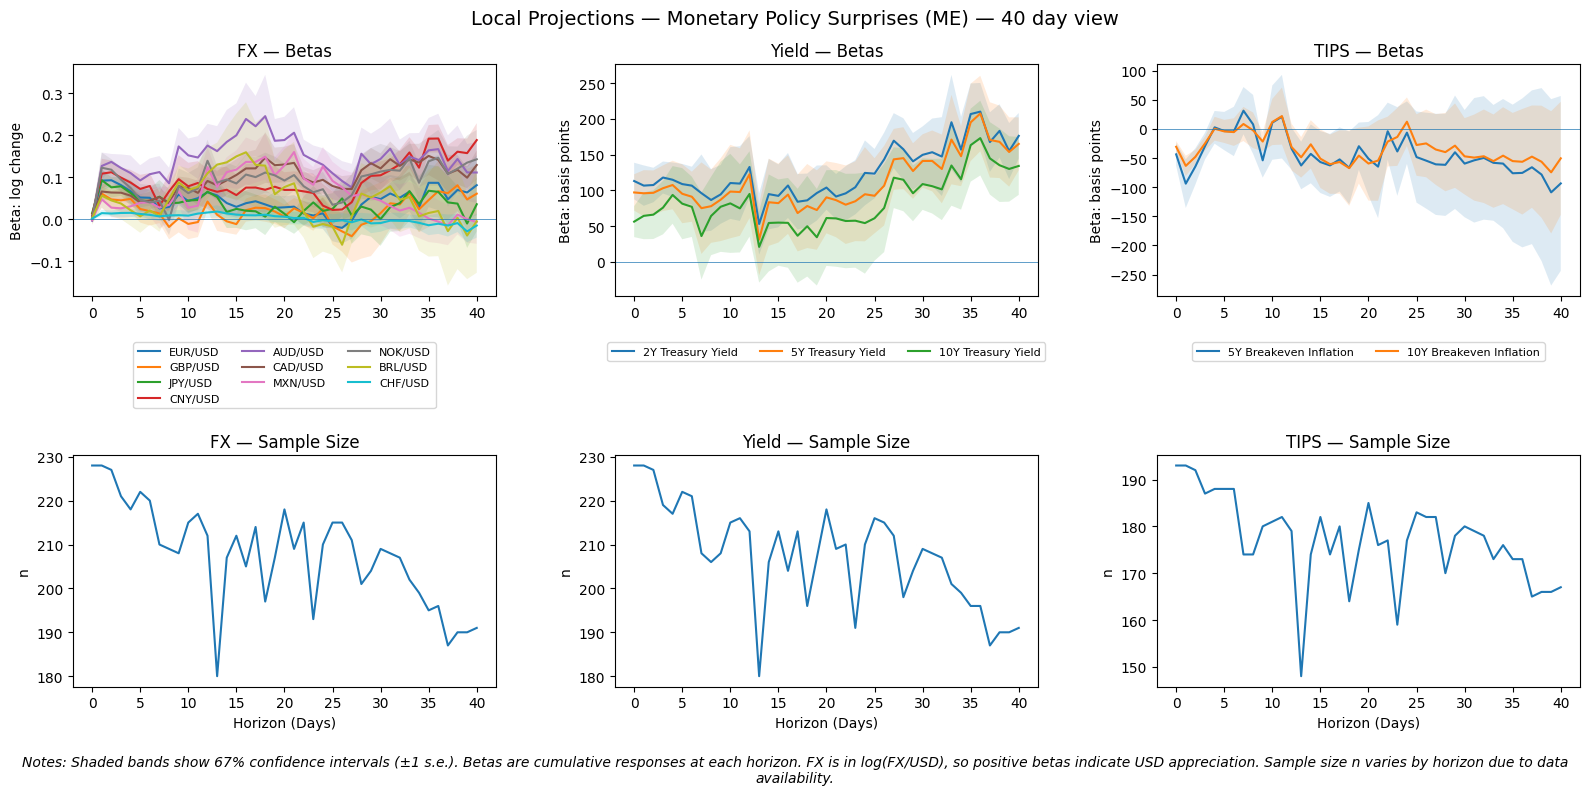

In [ ]:
# PLOT lp limited
lp_plot = lp.copy()

asset_classes = ["FX", "Yield", "TIPS"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for col, asset_class in enumerate(asset_classes):

    beta_ax = axes[0, col]   # top row
    n_ax    = axes[1, col]   # bottom row

    data = lp_plot[lp_plot["asset_class"] == asset_class].copy()

    # ----- TOP ROW: BETAS -----
    for asset in data["asset"].unique():
        d = data[data["asset"] == asset].sort_values("h")
        beta_ax.plot(d["h"], d["beta"], label=asset)
        beta_ax.fill_between(
            d["h"],
            d["ci_lo_67"],
            d["ci_hi_67"],
            alpha=0.15,
            linewidth=0
        )

    beta_ax.axhline(0, linewidth=0.5)
    beta_ax.set_title(f"{asset_class} — Betas")
    beta_ax.set_ylabel("Beta: log change" if asset_class == "FX" else "Beta: basis points")

    beta_ax.legend(
        fontsize=8,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=3,
        borderaxespad=0.0
    )

    # ----- BOTTOM ROW: SAMPLE SIZE -----
    n_by_h = data.groupby("h")["n"].min().sort_index()
    n_ax.plot(n_by_h.index, n_by_h.values)
    n_ax.set_title(f"{asset_class} — Sample Size")
    n_ax.set_ylabel("n")
    n_ax.set_xlabel("Horizon (Days)")

fig.suptitle("Local Projections — Monetary Policy Surprises (ME) — 40 day view", fontsize=14)

note = (
    "Notes: Shaded bands show 67% confidence intervals (±1 s.e.). "
    "Betas are cumulative responses at each horizon. "
    "FX is in log(FX/USD), so positive betas indicate USD appreciation. "
    "Sample size n varies by horizon due to data availability."
)
fig.text(
    0.5, 0.01, note,
    ha="center", va="bottom", fontsize=10, style="italic",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=4),
    wrap=True
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()

fig.savefig("output/part4_projections_40d.png", dpi=300, bbox_inches="tight")


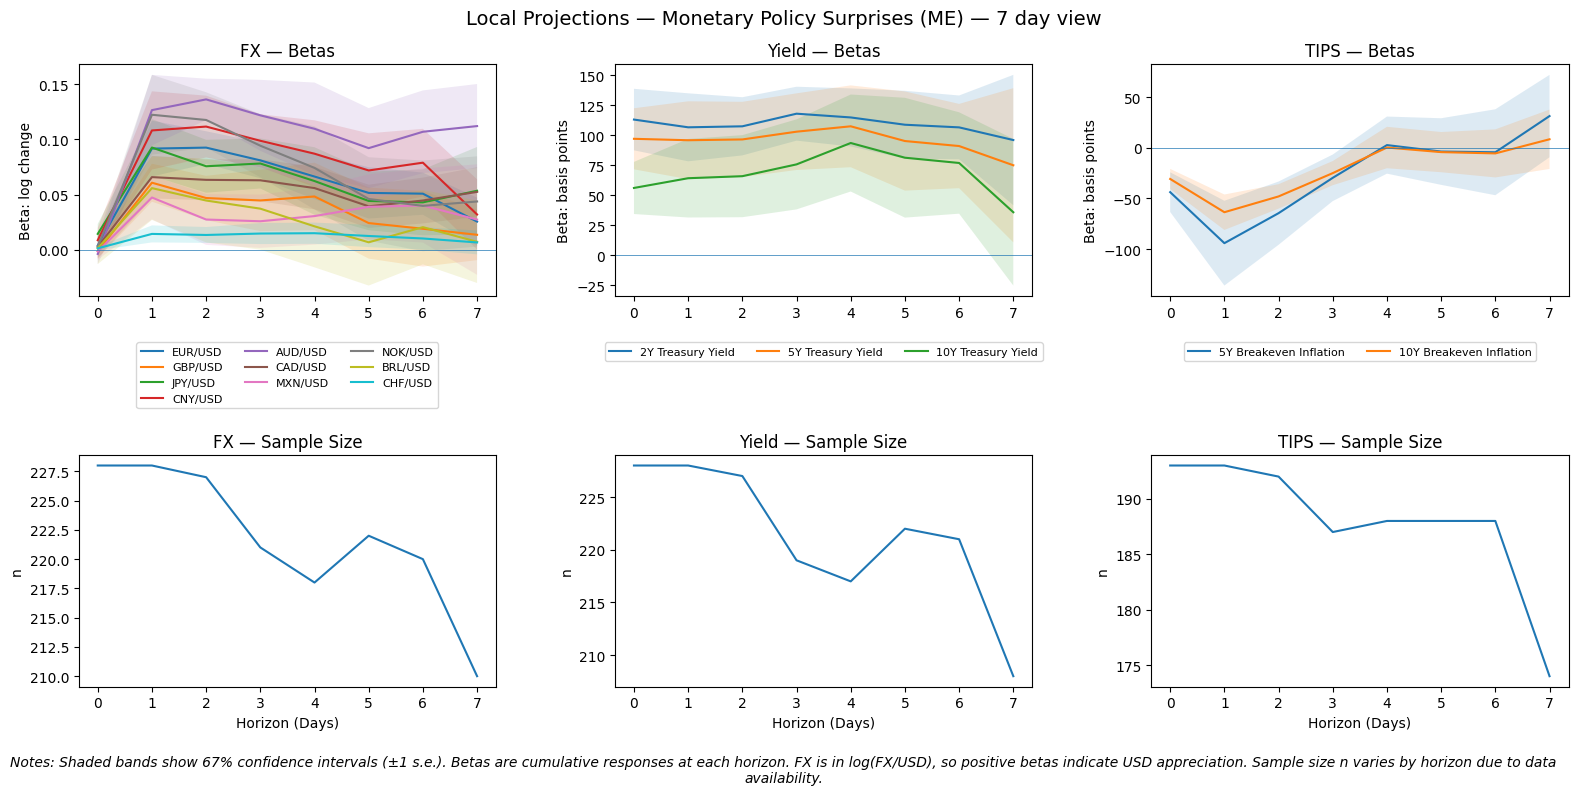

In [ ]:
# PLOT lp limited
lp_plot = lp[lp["h"] <= 7].copy()

asset_classes = ["FX", "Yield", "TIPS"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for col, asset_class in enumerate(asset_classes):

    beta_ax = axes[0, col]   # top row
    n_ax    = axes[1, col]   # bottom row

    data = lp_plot[lp_plot["asset_class"] == asset_class].copy()

    # ----- TOP ROW: BETAS -----
    for asset in data["asset"].unique():
        d = data[data["asset"] == asset].sort_values("h")
        beta_ax.plot(d["h"], d["beta"], label=asset)
        beta_ax.fill_between(
            d["h"],
            d["ci_lo_67"],
            d["ci_hi_67"],
            alpha=0.15,
            linewidth=0
        )

    beta_ax.axhline(0, linewidth=0.5)
    beta_ax.set_title(f"{asset_class} — Betas")
    beta_ax.set_ylabel("Beta: log change" if asset_class == "FX" else "Beta: basis points")

    beta_ax.legend(
        fontsize=8,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.2),
        ncol=3,
        borderaxespad=0.0
    )

    # ----- BOTTOM ROW: SAMPLE SIZE -----
    n_by_h = data.groupby("h")["n"].min().sort_index()
    n_ax.plot(n_by_h.index, n_by_h.values)
    n_ax.set_title(f"{asset_class} — Sample Size")
    n_ax.set_ylabel("n")
    n_ax.set_xlabel("Horizon (Days)")

fig.suptitle("Local Projections — Monetary Policy Surprises (ME) — 7 day view", fontsize=14)

note = (
    "Notes: Shaded bands show 67% confidence intervals (±1 s.e.). "
    "Betas are cumulative responses at each horizon. "
    "FX is in log(FX/USD), so positive betas indicate USD appreciation. "
    "Sample size n varies by horizon due to data availability."
)
fig.text(
    0.5, 0.01, note,
    ha="center", va="bottom", fontsize=10, style="italic",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=4),
    wrap=True
)

plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()

fig.savefig("output/part4_projections_7d.png", dpi=300, bbox_inches="tight")
